In [102]:
import xarray as xr
import dask.array as da
import numpy as np
import pandas as pd
import glob, os
from sklearn.decomposition import IncrementalPCA 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [103]:

# Opcional: cartopy para mapas más bonitos
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    CARTOPY = True
except Exception:
    CARTOPY = False
    print("cartopy no disponible: se usarán pcolormesh simples.")

In [ ]:

base_250 = r"C:\Users\BERTHA\TP_2\final\ERA5_250hPa"
base_500 = r"C:\Users\BERTHA\TP_2\final\ERA5_500hPa"
base_1000 = r"C:\Users\BERTHA\TP_2\final\ERA5_1000hPa"

output_dir = r"C:\Users\BERTHA\TP_2\final\pca_output"
os.makedirs(output_dir, exist_ok=True)

vars_to_use = ["z", "t", "u", "v", "r"]
levels_needed = [250.0, 500.0, 1000.0]
synoptic_hours = [0, 6, 12, 18]

# Parámetros de procesamiento por lotes
batch_size = 20         # Ajusta si tienes más/menos RAM
n_components = 10       # cuántos componentes queremos sacar (puedes aumentar)


In [105]:
def list_nc_recursive(base_dir):
    return sorted(glob.glob(os.path.join(base_dir, "**", "*.nc"), recursive=True))


PASO 1

In [106]:
# 1) Abrir archivos por nivel (igual que antes)
files_250 = list_nc_recursive(base_250)
files_500 = list_nc_recursive(base_500)
files_1000 = list_nc_recursive(base_1000)
print("Encontrados:", len(files_250), "250hPa;", len(files_500), "500hPa;", len(files_1000), "1000hPa")


Encontrados: 67 250hPa; 67 500hPa; 67 1000hPa


In [107]:

def open_level(files, level_label):
    if len(files) == 0:
        raise FileNotFoundError(f"No se encontraron archivos en {level_label}")
    ds = xr.open_mfdataset(
        files,
        combine='nested',
        concat_dim='valid_time',
        parallel=False
    )
    if 'valid_time' not in ds.coords and 'time' in ds.coords:
        ds = ds.rename({'time':'valid_time'})
    if 'pressure_level' not in ds.coords and 'level' in ds.coords:
        ds = ds.rename({'level':'pressure_level'})
    return ds

ds250 = open_level(files_250, "250hPa")
ds500 = open_level(files_500, "500hPa")
ds1000 = open_level(files_1000, "1000hPa")

ds_all = xr.concat([ds250, ds500, ds1000], dim='pressure_level')
ds_all = ds_all.assign_coords(pressure_level = ds_all['pressure_level'].values)


PASO 2

In [108]:
# 2) Filtrar horas sinópticas
ds_all = ds_all.sel(valid_time = ds_all['valid_time'].dt.hour.isin(synoptic_hours))
print("Número de instantes tras filtrar horas:", ds_all.valid_time.size)


Número de instantes tras filtrar horas: 840


PASO 3

In [109]:
# 3) Subconjunto de variables y orden de dims
for v in vars_to_use:
    if v not in ds_all.data_vars:
        raise KeyError(f"Variable {v} no encontrada. Disponibles: {list(ds_all.data_vars)}")

ds_sub = ds_all[vars_to_use].transpose('valid_time', 'pressure_level', 'latitude', 'longitude')

lat = ds_sub['latitude'].values
lon = ds_sub['longitude'].values
nlat = lat.size
nlon = lon.size
nlev = ds_sub['pressure_level'].size
ntime = ds_sub['valid_time'].size
print("Grid:", nlat, "x", nlon, " - niveles:", nlev, " - tiempos:", ntime)



Grid: 281 x 241  - niveles: 3  - tiempos: 840


PASO 4

In [110]:
# 4) Construir X como DASK concatenando variables 
# Para cada variable tomamos .data (esto es un dask array si xarray abrió con dask)
mat_list = []
for var in vars_to_use:
    arr_da = ds_sub[var].data  # dask array shape (time, level, lat, lon)
    # Reordenar y colapsar las últimas 3 dimensiones a 1 feature-dim
    arr_da_resh = arr_da.reshape(ntime, -1)   # dask reshaping, no compute
    mat_list.append(arr_da_resh)

X_da = da.concatenate(mat_list, axis=1)  # shape (ntime, total_features) - dask array
total_features = X_da.shape[1]
print("Shape DASK X:", X_da.shape)

Shape DASK X: (840, 1015815)


PASO 5

In [111]:
# 5) StandardScaler parcial: aprender mean & std por lotes 
scaler = StandardScaler(with_mean=True, with_std=True)
print("Ajustando StandardScaler por batches...")
for i in range(0, ntime, batch_size):
    i2 = min(i+batch_size, ntime)
    block = X_da[i:i2].compute()   # sólo este bloque entra en RAM
    scaler.partial_fit(block)
    print(f" scaler fit batch {i}:{i2}")


Ajustando StandardScaler por batches...
 scaler fit batch 0:20
 scaler fit batch 20:40
 scaler fit batch 40:60
 scaler fit batch 60:80
 scaler fit batch 80:100
 scaler fit batch 100:120
 scaler fit batch 120:140
 scaler fit batch 140:160
 scaler fit batch 160:180
 scaler fit batch 180:200
 scaler fit batch 200:220
 scaler fit batch 220:240
 scaler fit batch 240:260
 scaler fit batch 260:280
 scaler fit batch 280:300
 scaler fit batch 300:320
 scaler fit batch 320:340
 scaler fit batch 340:360
 scaler fit batch 360:380
 scaler fit batch 380:400
 scaler fit batch 400:420
 scaler fit batch 420:440
 scaler fit batch 440:460
 scaler fit batch 460:480
 scaler fit batch 480:500
 scaler fit batch 500:520
 scaler fit batch 520:540
 scaler fit batch 540:560
 scaler fit batch 560:580
 scaler fit batch 580:600
 scaler fit batch 600:620
 scaler fit batch 620:640
 scaler fit batch 640:660
 scaler fit batch 660:680
 scaler fit batch 680:700
 scaler fit batch 700:720
 scaler fit batch 720:740
 scaler 

PASO 6

In [112]:
# 6) IncrementalPCA por lotes
ipca = IncrementalPCA(n_components=n_components)
print("Entrenando IncrementalPCA por batches...")
for i in range(0, ntime, batch_size):
    i2 = min(i+batch_size, ntime)
    block = X_da[i:i2].compute()
    block_std = scaler.transform(block)   # centrar y escalar (en RAM sólo el bloque)
    ipca.partial_fit(block_std)
    print(f" ipca partial_fit batch {i}:{i2}")

Entrenando IncrementalPCA por batches...
 ipca partial_fit batch 0:20
 ipca partial_fit batch 20:40
 ipca partial_fit batch 40:60
 ipca partial_fit batch 60:80
 ipca partial_fit batch 80:100
 ipca partial_fit batch 100:120
 ipca partial_fit batch 120:140
 ipca partial_fit batch 140:160
 ipca partial_fit batch 160:180
 ipca partial_fit batch 180:200
 ipca partial_fit batch 200:220
 ipca partial_fit batch 220:240
 ipca partial_fit batch 240:260
 ipca partial_fit batch 260:280
 ipca partial_fit batch 280:300
 ipca partial_fit batch 300:320
 ipca partial_fit batch 320:340
 ipca partial_fit batch 340:360
 ipca partial_fit batch 360:380
 ipca partial_fit batch 380:400
 ipca partial_fit batch 400:420
 ipca partial_fit batch 420:440
 ipca partial_fit batch 440:460
 ipca partial_fit batch 460:480
 ipca partial_fit batch 480:500
 ipca partial_fit batch 500:520
 ipca partial_fit batch 520:540
 ipca partial_fit batch 540:560
 ipca partial_fit batch 560:580
 ipca partial_fit batch 580:600
 ipca par

PASO 7

In [113]:
# 7) Obtener scores (transform) por lotes
scores_list = []
for i in range(0, ntime, batch_size):
    i2 = min(i+batch_size, ntime)
    block = X_da[i:i2].compute()
    block_std = scaler.transform(block)
    score_chunk = ipca.transform(block_std)
    scores_list.append(score_chunk)
    print(f" transform batch {i}:{i2}")

scores = np.vstack(scores_list)  # shape (ntime, n_components)
print("Scores shape:", scores.shape)

 transform batch 0:20
 transform batch 20:40
 transform batch 40:60
 transform batch 60:80
 transform batch 80:100
 transform batch 100:120
 transform batch 120:140
 transform batch 140:160
 transform batch 160:180
 transform batch 180:200
 transform batch 200:220
 transform batch 220:240
 transform batch 240:260
 transform batch 260:280
 transform batch 280:300
 transform batch 300:320
 transform batch 320:340
 transform batch 340:360
 transform batch 360:380
 transform batch 380:400
 transform batch 400:420
 transform batch 420:440
 transform batch 440:460
 transform batch 460:480
 transform batch 480:500
 transform batch 500:520
 transform batch 520:540
 transform batch 540:560
 transform batch 560:580
 transform batch 580:600
 transform batch 600:620
 transform batch 620:640
 transform batch 640:660
 transform batch 660:680
 transform batch 680:700
 transform batch 700:720
 transform batch 720:740
 transform batch 740:760
 transform batch 760:780
 transform batch 780:800
 transform

PASO 8

In [114]:
# 8) Scree plot (explained variance ratio)
explained = ipca.explained_variance_ratio_
cumvar = np.cumsum(explained)
df_var = pd.DataFrame({'PC': np.arange(1, len(explained)+1),
                       'explained_variance_ratio': explained,
                       'cumulative': cumvar})
df_var.to_csv(os.path.join(output_dir, "pca_variance_table_incremental.csv"), index=False)
plt.figure(figsize=(8,4))
plt.bar(np.arange(1, len(explained)+1), explained*100)
plt.plot(np.arange(1, len(explained)+1), cumvar*100, marker='o')
plt.xlabel('PC'); plt.ylabel('Varianza explicada (%)'); plt.title('Scree plot - Incremental PCA')
plt.grid(True); plt.tight_layout()
plt.savefig(os.path.join(output_dir, "scree_plot_incremental.png"), dpi=150); plt.close()


PASO 9

In [115]:
# 9) Mapear componentes a campos espaciales
components = ipca.components_   # shape (n_components, total_features)

features_per_var = int(nlev * nlat * nlon)
def component_to_fields(component_vector):
    out = {}
    for vi, var in enumerate(vars_to_use):
        start = vi * features_per_var
        end = start + features_per_var
        vec = component_vector[start:end]
        arr = vec.reshape(nlev, nlat, nlon)
        for li, level in enumerate(ds_sub['pressure_level'].values):
            out[(var, float(level))] = arr[li,:,:]
    return out


In [117]:
# Ploteo

def plot_pc_variable_panels_fixed(pc_number, variable, lat, lon, output_dir):
    
    # Obtener campos para esta PC
    pc_index = pc_number - 1
    fields = component_to_fields(components[pc_index])
    
    # Crear figura
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f'PC{pc_number} - {variable.upper()} - Patrón de Carga', 
                 fontsize=14, fontweight='bold', y=0.95)
    
    levels_to_plot = [250.0, 500.0, 1000.0]
    
    # CONFIGURACIÓN DE COLORES MEJORADA
    color_config = {
        'z': {'cmap': 'viridis', 'label': 'Geopotencial (m²/s²)'},
        't': {'cmap': 'RdBu_r', 'label': 'Temperatura (K) - Rojo: Cálido, Azul: Frío'},
        'u': {'cmap': 'RdBu_r', 'label': 'Viento Zonal (m/s) - Rojo: Este, Azul: Oeste'},
        'v': {'cmap': 'RdBu_r', 'label': 'Viento Meridional (m/s) - Rojo: Norte, Azul: Sur'},
        'r': {'cmap': 'BrBG', 'label': 'Humedad Relativa (%)'}
    }
    
    config = color_config.get(variable, {'cmap': 'viridis', 'label': 'Loading PCA'})
    cmap = config['cmap']
    cbar_label = config['label']
    
    # Calcular rango común para colorbar consistente
    all_data = []
    for level in levels_to_plot:
        field_data = fields.get((variable, level))
        if field_data is not None:
            all_data.append(field_data)
    
    if not all_data:
        print(f"No hay datos: {variable}")
        return
    
    # Determinar rango
    if variable in ['u', 'v', 't']:  # Escala divergente
        max_abs = max(np.nanmax(np.abs(data)) for data in all_data)
        vmin, vmax = -max_abs, max_abs
    else:  # Escala secuencial
        vmin = min(np.nanmin(data) for data in all_data)
        vmax = max(np.nanmax(data) for data in all_data)
    
    mesh = None
    
    for i, level in enumerate(levels_to_plot):
        field_data = fields.get((variable, level))
        if field_data is None:
            continue
            
        if CARTOPY:
            import cartopy.crs as ccrs
            import cartopy.feature as cfeature
            
            ax = fig.add_subplot(1, 3, i+1, projection=ccrs.PlateCarree())
            
            # Plot principal
            mesh = ax.contourf(lon, lat, field_data, levels=15,
                              transform=ccrs.PlateCarree(), cmap=cmap,
                              vmin=vmin, vmax=vmax, extend='both')
            
            # Elementos esenciales del mapa
            ax.coastlines(linewidth=0.8, color='black')
            ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor='gray', linestyle=':')
            
            # GRIDLINES SIMPLES 
            gl = ax.gridlines(
                draw_labels=True, 
                linewidth=0.3, 
                color='gray', 
                alpha=0.5,
                linestyle='--'
            )
            
            # etiquetas
            gl.top_labels = False
            gl.right_labels = False
            gl.left_labels = (i == 0)    # Latitud 
            gl.bottom_labels = (i == 1)  # Longitud
            
        else:
            # Versión sin Cartopy
            ax = axes[i]
            mesh = ax.contourf(lon, lat, field_data, levels=15, cmap=cmap,
                              vmin=vmin, vmax=vmax)
            
            # Coordenadas solo en bordes
            if i == 0:
                ax.set_ylabel('Latitud (°)', fontsize=10)
            if i == 1:
                ax.set_xlabel('Longitud (°)', fontsize=10)
            
            ax.grid(True, alpha=0.3)
        
        ax.set_title(f'{int(level)} hPa', fontsize=11, fontweight='bold')
    
    # COLORBAR 
    if mesh is not None:
        plt.tight_layout(rect=[0, 0.05, 1, 0.93])  # Espacio para colorbar
        
        # Colorbar horizontal 
        cbar_ax = fig.add_axes([0.25, 0.02, 0.5, 0.02])
        cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
        cbar.set_label(cbar_label, fontsize=10, labelpad=8)
        cbar.ax.tick_params(labelsize=8)
    
    # Guardar
    filename = os.path.join(output_dir, f"PC{pc_number}_{variable}_panel.png")
    plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.close()
    
    print(f"Panel guardado: {filename}")

def generate_all_pc_panels(output_dir, n_pcs=4):
    """
    Generación de todos los paneles
    """
    print("=== GENERANDO PANELES DE COMPONENTES PRINCIPALES ===")
    
    variables = ['z', 't', 'u', 'v', 'r']
    
    for pc in range(1, n_pcs + 1):
        print(f"Procesando PC{pc}...")
        for var in variables:
            try:
                plot_pc_variable_panels_fixed(pc, var, lat, lon, output_dir)
            except Exception as e:
                print(f"Error con PC{pc}_{var}: {str(e)[:100]}...")
    
print("Iniciando generación de paneles de componentes...")

# Paneles agrupados
generate_all_pc_panels(output_dir, n_pcs=4)


Iniciando generación de paneles de componentes...
=== GENERANDO PANELES DE COMPONENTES PRINCIPALES ===
Procesando PC1...
Panel guardado: C:\Users\BERTHA\TP_2\final\pca_output\PC1_z_panel.png
Panel guardado: C:\Users\BERTHA\TP_2\final\pca_output\PC1_t_panel.png
Panel guardado: C:\Users\BERTHA\TP_2\final\pca_output\PC1_u_panel.png
Panel guardado: C:\Users\BERTHA\TP_2\final\pca_output\PC1_v_panel.png
Panel guardado: C:\Users\BERTHA\TP_2\final\pca_output\PC1_r_panel.png
Procesando PC2...
Panel guardado: C:\Users\BERTHA\TP_2\final\pca_output\PC2_z_panel.png
Panel guardado: C:\Users\BERTHA\TP_2\final\pca_output\PC2_t_panel.png
Panel guardado: C:\Users\BERTHA\TP_2\final\pca_output\PC2_u_panel.png
Panel guardado: C:\Users\BERTHA\TP_2\final\pca_output\PC2_v_panel.png
Panel guardado: C:\Users\BERTHA\TP_2\final\pca_output\PC2_r_panel.png
Procesando PC3...
Panel guardado: C:\Users\BERTHA\TP_2\final\pca_output\PC3_z_panel.png
Panel guardado: C:\Users\BERTHA\TP_2\final\pca_output\PC3_t_panel.png
Pan

PASO 10

In [118]:
# 10) Reconstrucción usando "N" PCs 

N = 3
components_N = components[:N, :]   # (N, features)

# Reconstruimos el primer instante para comenzar
orig_idx = 0
orig_vec = X_da[orig_idx:orig_idx+1].compute().reshape(-1)   # (features,)
recon_std = scores[orig_idx:orig_idx+1, :N].dot(components_N)   # (1, features)
recon_vec = scaler.inverse_transform(recon_std).reshape(-1)


In [121]:
# CONFIGURACIÓN CENTRALIZADA DE COLORES
COLOR_CONFIG = {
    'z': {'seq': 'viridis', 'diff': 'RdBu_r', 'label': 'Geopotencial (m²/s²)'},
    't': {'seq': 'hot', 'diff': 'RdBu_r', 'label': 'Temperatura (K)'},
    'u': {'seq': 'coolwarm', 'diff': 'RdBu_r', 'label': 'Viento Zonal (m/s)'},
    'v': {'seq': 'coolwarm', 'diff': 'RdBu_r', 'label': 'Viento Meridional (m/s)'},
    'r': {'seq': 'Blues', 'diff': 'BrBG', 'label': 'Humedad Relativa (%)'}
}

def setup_cartopy_axis(ax, data, lon, lat, cmap, vmin, vmax):
    """eje Cartopy con plot y elementos del mapa"""
    mesh = ax.contourf(lon, lat, data, levels=15,
                      transform=ccrs.PlateCarree(), cmap=cmap,
                      vmin=vmin, vmax=vmax, extend='both')
    ax.coastlines(linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3, edgecolor='gray')
    
    gl = ax.gridlines(draw_labels=True, linewidth=0.2, alpha=0.4)
    gl.top_labels = gl.right_labels = False
    return mesh

def setup_simple_axis(ax, data, lon, lat, cmap, vmin, vmax, i):
    """eje simple sin Cartopy"""
    mesh = ax.contourf(lon, lat, data, levels=15, cmap=cmap,
                      vmin=vmin, vmax=vmax)
    if i == 0:
        ax.set_ylabel('Latitud (°)')
    if i == 1:
        ax.set_xlabel('Longitud (°)')
    ax.grid(True, alpha=0.3)
    return mesh

def plot_comparison_panels_optimized(orig_vec, recon_vec, idx_label, output_dir):
    
    for vi, var in enumerate(vars_to_use):
        start = vi * features_per_var
        end = start + features_per_var
        
        orig_arr = orig_vec[start:end].reshape(nlev, nlat, nlon)
        rec_arr = recon_vec[start:end].reshape(nlev, nlat, nlon)
        config = COLOR_CONFIG[var]
        
        for li, level in enumerate(ds_sub['pressure_level'].values):
            orig_data = orig_arr[li, :, :]
            rec_data = rec_arr[li, :, :]
            diff_data = orig_data - rec_data
            
            # Crear figura con 3 columnas
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            fig.suptitle(f'Comparación PC{N} - {var.upper()} {int(level)} hPa - Índice {idx_label}', 
                        fontsize=14, fontweight='bold', y=0.95)
            
            # Determinar rangos (MANTIENE LA LÓGICA ORIGINAL)
            if var in ['u', 'v', 't']:
                max_abs_orig = max(np.nanmax(np.abs(orig_data)), np.nanmax(np.abs(rec_data)))
                vmin_seq, vmax_seq = -max_abs_orig, max_abs_orig
                max_abs_diff = np.nanmax(np.abs(diff_data))
                vmin_diff, vmax_diff = -max_abs_diff, max_abs_diff
            else:
                vmin_seq = min(np.nanmin(orig_data), np.nanmin(rec_data))
                vmax_seq = max(np.nanmax(orig_data), np.nanmax(rec_data))
                max_abs_diff = np.nanmax(np.abs(diff_data))
                vmin_diff, vmax_diff = -max_abs_diff, max_abs_diff
            
            mesh_sequential = None
            mesh_divergent = None
            
            #ORIGINAL
            if CARTOPY:
                ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())
                mesh_sequential = setup_cartopy_axis(ax1, orig_data, lon, lat, 
                                                   config['seq'], vmin_seq, vmax_seq)
                ax1.set_title('ORIGINAL', fontsize=12, fontweight='bold', pad=10)
                # Grid labels solo en primer panel
                gl1 = ax1.gridlines(draw_labels=True, linewidth=0.2, alpha=0.4)
                gl1.top_labels = gl1.right_labels = False
            else:
                ax1 = axes[0]
                mesh_sequential = setup_simple_axis(ax1, orig_data, lon, lat, 
                                                  config['seq'], vmin_seq, vmax_seq, 0)
                ax1.set_title('ORIGINAL', fontsize=12, fontweight='bold')
                ax1.set_ylabel('Latitud (°)')
            
            #RECONSTRUIDO
            if CARTOPY:
                ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.PlateCarree())
                setup_cartopy_axis(ax2, rec_data, lon, lat, 
                                 config['seq'], vmin_seq, vmax_seq)
                ax2.set_title(f'RECON N={N}', fontsize=12, fontweight='bold', pad=10)
                # Grid labels solo en panel central
                gl2 = ax2.gridlines(draw_labels=True, linewidth=0.2, alpha=0.4)
                gl2.top_labels = gl2.right_labels = gl2.left_labels = False
                gl2.bottom_labels = True
            else:
                ax2 = axes[1]
                setup_simple_axis(ax2, rec_data, lon, lat, 
                                config['seq'], vmin_seq, vmax_seq, 1)
                ax2.set_title(f'RECON N={N}', fontsize=12, fontweight='bold')
                ax2.set_xlabel('Longitud (°)')
            
            #DIFERENCIA
            if CARTOPY:
                ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())
                mesh_divergent = setup_cartopy_axis(ax3, diff_data, lon, lat, 
                                                  config['diff'], vmin_diff, vmax_diff)
                ax3.set_title('DIFERENCIA', fontsize=12, fontweight='bold', pad=10)
                ax3.gridlines(draw_labels=False, linewidth=0.2, alpha=0.4)
            else:
                ax3 = axes[2]
                mesh_divergent = setup_simple_axis(ax3, diff_data, lon, lat, 
                                                 config['diff'], vmin_diff, vmax_diff, 2)
                ax3.set_title('DIFERENCIA', fontsize=12, fontweight='bold')
            
            # COLORBARS 
            plt.tight_layout(rect=[0, 0.08, 1, 0.93])
            
            # Colorbar para (ORIGINAL y RECON)
            if mesh_sequential is not None:
                cbar_seq_ax = fig.add_axes([0.15, 0.03, 0.25, 0.02])
                cbar_seq = fig.colorbar(mesh_sequential, cax=cbar_seq_ax, orientation='horizontal')
                cbar_seq.set_label(f'{config["label"]} - Campos', fontsize=9)
                cbar_seq.ax.tick_params(labelsize=8)
            
            # Colorbar para diferencia
            if mesh_divergent is not None:
                cbar_diff_ax = fig.add_axes([0.65, 0.03, 0.25, 0.02])
                cbar_diff = fig.colorbar(mesh_divergent, cax=cbar_diff_ax, orientation='horizontal')
                cbar_diff.set_label(f'{config["label"]} - Diferencia', fontsize=9)
                cbar_diff.ax.tick_params(labelsize=8)
            
            # Guardar
            filename = os.path.join(output_dir, f"comparison_idx{idx_label}_{var}_{int(level)}hPa_panel.png")
            plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
            plt.close()

def plot_variable_across_levels_optimized(orig_vec, recon_vec, idx_label, output_dir):  #para paneles y niveles
    
    for var in vars_to_use:
        start = vars_to_use.index(var) * features_per_var
        end = start + features_per_var
        
        orig_arr = orig_vec[start:end].reshape(nlev, nlat, nlon)
        rec_arr = recon_vec[start:end].reshape(nlev, nlat, nlon)
        config = COLOR_CONFIG[var]
        
        # Configuración de colores simplificada
        if var in ['u', 'v', 't']:
            cmap_seq = 'RdBu_r'
            cmap_diff = 'RdBu_r'
        else:
            cmap_seq = config['seq']
            cmap_diff = config['diff']
        
        # ORIGINAL a través de niveles
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle(f'ORIGINAL - {var.upper()} - Todos los Niveles - Índice {idx_label}', 
                    fontsize=14, fontweight='bold', y=0.95)
        
        mesh_orig = None
        for i, level in enumerate([250.0, 500.0, 1000.0]):
            li = list(ds_sub['pressure_level'].values).index(level)
            orig_data = orig_arr[li, :, :]
            
            if CARTOPY:
                ax = fig.add_subplot(1, 3, i+1, projection=ccrs.PlateCarree())
                mesh_orig = setup_cartopy_axis(ax, orig_data, lon, lat, cmap_seq, 
                                             np.nanmin(orig_data), np.nanmax(orig_data))
                gl = ax.gridlines(draw_labels=True, linewidth=0.2, alpha=0.4)
                gl.top_labels = gl.right_labels = False
                gl.left_labels = (i == 0)
                gl.bottom_labels = (i == 1)
            else:
                ax = axes[i]
                mesh_orig = setup_simple_axis(ax, orig_data, lon, lat, cmap_seq,
                                            np.nanmin(orig_data), np.nanmax(orig_data), i)
            
            ax.set_title(f'{int(level)} hPa', fontsize=11, fontweight='bold')
        
        # Colorbar para original
        if mesh_orig is not None:
            plt.tight_layout(rect=[0, 0.05, 1, 0.93])
            cbar_ax = fig.add_axes([0.25, 0.02, 0.5, 0.02])
            cbar = fig.colorbar(mesh_orig, cax=cbar_ax, orientation='horizontal')
            cbar.set_label(f'{var.upper()} - Valores Originales', fontsize=10)
            cbar.ax.tick_params(labelsize=8)
        
        filename = os.path.join(output_dir, f"original_{var}_all_levels_idx{idx_label}.png")
        plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
        plt.close()
        
        # DIFERENCIAS a través de niveles
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle(f'DIFERENCIAS - {var.upper()} - Todos los Niveles - Índice {idx_label}', 
                    fontsize=14, fontweight='bold', y=0.95)
        
        mesh_diff = None
        for i, level in enumerate([250.0, 500.0, 1000.0]):
            li = list(ds_sub['pressure_level'].values).index(level)
            orig_data = orig_arr[li, :, :]
            rec_data = rec_arr[li, :, :]
            diff_data = orig_data - rec_data
            
            max_abs = np.nanmax(np.abs(diff_data))
            
            if CARTOPY:
                ax = fig.add_subplot(1, 3, i+1, projection=ccrs.PlateCarree())
                mesh_diff = setup_cartopy_axis(ax, diff_data, lon, lat, cmap_diff, 
                                             -max_abs, max_abs)
                gl = ax.gridlines(draw_labels=True, linewidth=0.2, alpha=0.4)
                gl.top_labels = gl.right_labels = False
                gl.left_labels = (i == 0)
                gl.bottom_labels = (i == 1)
            else:
                ax = axes[i]
                mesh_diff = setup_simple_axis(ax, diff_data, lon, lat, cmap_diff,
                                            -max_abs, max_abs, i)
            
            ax.set_title(f'{int(level)} hPa', fontsize=11, fontweight='bold')
        
        # Colorbar para diferencias
        if mesh_diff is not None:
            plt.tight_layout(rect=[0, 0.05, 1, 0.93])
            cbar_ax = fig.add_axes([0.25, 0.02, 0.5, 0.02])
            cbar = fig.colorbar(mesh_diff, cax=cbar_ax, orientation='horizontal')
            cbar.set_label(f'{var.upper()} - Diferencias (Original - Reconstruido)', fontsize=10)
            cbar.ax.tick_params(labelsize=8)
        
        filename = os.path.join(output_dir, f"diff_{var}_all_levels_idx{idx_label}.png")
        plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.1)
        plt.close()
        
        print(f"Paneles de niveles guardados para {var}")

# Ejecutar
plot_comparison_panels_optimized(orig_vec, recon_vec, orig_idx, output_dir)
plot_variable_across_levels_optimized(orig_vec, recon_vec, orig_idx, output_dir)

Paneles de niveles guardados para z
Paneles de niveles guardados para t
Paneles de niveles guardados para u
Paneles de niveles guardados para v
Paneles de niveles guardados para r


PASO 11

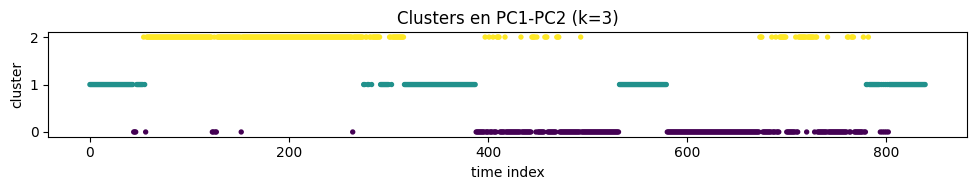

In [124]:
# 11) Clustering K-Means optimizado

X_pcs_2d = scores[:, :2]
kmeans_2d = KMeans(n_clusters=3, random_state=0).fit(X_pcs_2d)
labels_2d = kmeans_2d.labels_

# Guardar serie temporal simple de clusters 
plt.figure(figsize=(10,2))
plt.scatter(np.arange(len(labels_2d)), labels_2d, c=labels_2d, s=8)
plt.xlabel('time index'); plt.ylabel('cluster'); plt.title('Clusters en PC1-PC2 (k=3)')
plt.tight_layout(); plt.savefig(os.path.join(output_dir, "clusters_timeseries_2d.png")); plt.show()


In [126]:

# Análisis
N_CLUSTERS = 3
RANDOM_STATE = 42

# Usamos los scores de PC1, PC2, y PC3 para el análisis real
scores_N = scores[:, :N_CLUSTERS] 

# Modelo K-Means para análisis principal
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, n_init=10)
kmeans.fit(scores_N)

# Clasificación final para el análisis
cluster_labels = kmeans.labels_

# Guardar centroides (análisis principal)
cluster_centers = pd.DataFrame(
    kmeans.cluster_centers_, 
    columns=[f"PC{i+1}" for i in range(N_CLUSTERS)]
)
cluster_centers.to_csv(os.path.join(output_dir, "kmeans_3_cluster_centers.csv"), 
                      index_label="Cluster_ID")
print(f"Centroides de Clusters K={N_CLUSTERS} guardados.")

# Guardar etiquetas temporales (análisis principal)
df_clusters = pd.DataFrame({
    'valid_time': ds_all.valid_time.values,
    'Cluster_ID': cluster_labels
})
df_clusters.to_csv(os.path.join(output_dir, "friajes_cluster_labels.csv"), index=False)
print(f"Etiquetas de eventos K={N_CLUSTERS} guardadas.")

print("Análisis de clustering completado.")

Centroides de Clusters K=3 guardados.
Etiquetas de eventos K=3 guardadas.
Análisis de clustering completado.


PASO 12

In [ ]:
# 12) Cálculo de medias por cluster - VERSIÓN CORREGIDA DEFINITIVA

def calculate_cluster_means():
    """Calcula medias por cluster"""
    print("Calculando medias por cluster...")
    
    k = k_clusters
    sums = np.zeros((k, int(total_features)), dtype=np.float64)
    counts = np.zeros(k, dtype=int)

    for i in range(0, ntime, batch_size):
        i2 = min(i + batch_size, ntime)
        block = X_da[i:i2].compute()
        for j in range(block.shape[0]):
            idx = i + j
            cl = int(labels[idx])
            sums[cl] += block[j].astype(np.float64)
            counts[cl] += 1
        print(f"  Procesado lote {i}:{i2}")

    # Calcular medias
    means = np.zeros_like(sums)
    for cl in range(k):
        if counts[cl] > 0:
            means[cl] = sums[cl] / counts[cl]
        else:
            print(f"Cluster {cl} vacío!")
    
    return means

# CONFIGURACIÓN DE COLORES ÓPTIMA
COLOR_CONFIG = {
    'z': {'cmap': 'terrain', 'label': 'Geopotencial (m²/s²)'},
    't': {'cmap': 'seismic', 'label': 'Temperatura (K)'},  # seismic para máximo contraste
    'u': {'cmap': 'RdBu_r', 'label': 'Viento Zonal (m/s)'},
    'v': {'cmap': 'RdBu_r', 'label': 'Viento Meridional (m/s)'},
    'r': {'cmap': 'BrBG', 'label': 'Humedad Relativa (%)'}
}

def plot_cluster_panels_final(means, output_dir):
    """
    
    """
    
    for cl in range(k_clusters):
        mean_vec = means[cl]
        
        for var in vars_to_use:
            # Crear figura
            fig = plt.figure(figsize=(16, 6))
            
            levels_to_plot = [250.0, 500.0, 1000.0]
            
            # Calcular rango común
            all_data = []
            for level in levels_to_plot:
                start = vars_to_use.index(var) * features_per_var
                end = start + features_per_var
                mean_arr = mean_vec[start:end].reshape(nlev, nlat, nlon)
                level_idx = list(ds_sub['pressure_level'].values).index(level)
                field_data = mean_arr[level_idx, :, :]
                all_data.append(field_data)
            
            # Determinar rango
            if var in ['u', 'v']:
                max_abs = max(np.nanmax(np.abs(data)) for data in all_data)
                vmin, vmax = -max_abs, max_abs
            elif var == 't':
                # Para temperatura, asegurar buen contraste
                data_min = min(np.nanmin(data) for data in all_data)
                data_max = max(np.nanmax(data) for data in all_data)
                range_val = data_max - data_min
                if range_val < 10:
                    center = (data_max + data_min) / 2
                    vmin = center - 5
                    vmax = center + 5
                else:
                    vmin = data_min
                    vmax = data_max
            else:
                vmin = min(np.nanmin(data) for data in all_data)
                vmax = max(np.nanmax(data) for data in all_data)
            
            for i, level in enumerate(levels_to_plot):
                field_data = all_data[i]
                
                import cartopy.crs as ccrs
                import cartopy.feature as cfeature
                
                # Posicionamiento manual
                left = 0.05 + i * 0.3
                bottom = 0.15
                width = 0.28
                height = 0.7
                
                ax = fig.add_axes([left, bottom, width, height], 
                                 projection=ccrs.PlateCarree())
                
                # Plot principal
                mesh = ax.contourf(lon, lat, field_data, levels=15,
                                  transform=ccrs.PlateCarree(), 
                                  cmap=COLOR_CONFIG[var]['cmap'],
                                  vmin=vmin, vmax=vmax,
                                  extend='both')
                
                # MAPA DE SUDAMÉRICA COMPLETO
                ax.coastlines(linewidth=1.0, color='black')
                ax.add_feature(cfeature.BORDERS, linewidth=0.7, edgecolor='gray')
                ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.2)
                ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.1)
                
                # Enfocar en Sudamérica
                ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], 
                             crs=ccrs.PlateCarree())
                
                # GRIDLINES MANUALES CORRECTAS - usando plot() en lugar de axhline/axvline
                lat_ticks = np.linspace(lat.min(), lat.max(), 5)
                lon_ticks = np.linspace(lon.min(), lon.max(), 5)
                
                # Líneas de latitud
                for lat_val in lat_ticks:
                    ax.plot([lon.min(), lon.max()], [lat_val, lat_val], 
                           color='gray', linewidth=0.3, alpha=0.5, linestyle='--',
                           transform=ccrs.PlateCarree())
                
                # Líneas de longitud
                for lon_val in lon_ticks:
                    ax.plot([lon_val, lon_val], [lat.min(), lat.max()], 
                           color='gray', linewidth=0.3, alpha=0.5, linestyle='--',
                           transform=ccrs.PlateCarree())
                
                # ETIQUETAS MANUALES de coordenadas
                if i == 0:  # Primer mapa: etiquetas de latitud
                    for lat_val in lat_ticks:
                        ax.text(lon.min() - 2, lat_val, f'{abs(lat_val):.0f}°{"S" if lat_val < 0 else "N"}', 
                               transform=ccrs.PlateCarree(), fontsize=8, 
                               verticalalignment='center', horizontalalignment='right',
                               bbox=dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.7))
                
                if i == 1:  # Mapa central: etiquetas de longitud
                    for lon_val in lon_ticks:
                        ax.text(lon_val, lat.min() - 2, f'{abs(lon_val):.0f}°{"W" if lon_val < 0 else "E"}', 
                               transform=ccrs.PlateCarree(), fontsize=8,
                               verticalalignment='top', horizontalalignment='center',
                               bbox=dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.7))
                
                ax.set_title(f'{var.upper()} - {int(level)} hPa', fontsize=11, fontweight='bold', pad=10)
            
            # Título principal
            fig.suptitle(f'Cluster {cl} - {var.upper()} - Patrón Promedio', 
                        fontsize=14, fontweight='bold', y=0.92)
            
            # Colorbar manual
            cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.03])
            cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
            cbar.set_label(COLOR_CONFIG[var]['label'], fontsize=11, fontweight='bold')
            cbar.ax.tick_params(labelsize=9)
            
            filename = os.path.join(output_dir, f"cluster{cl}_{var}_final.png")
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            plt.close()
            
            print(f"Panel final cluster {cl} - {var} guardado")

def plot_temperature_best(means, output_dir):
    """
    Temperatura con MÁXIMO CONTRASTE
    """
    for cl in range(k_clusters):
        mean_vec = means[cl]
        
        # Extraer datos de temperatura
        start = vars_to_use.index('t') * features_per_var
        end = start + features_per_var
        temp_arr = mean_vec[start:end].reshape(nlev, nlat, nlon)
        
        fig = plt.figure(figsize=(16, 6))
        
        levels_to_plot = [250.0, 500.0, 1000.0]
        
        # Calcular rango para MÁXIMO CONTRASTE
        all_temp_data = []
        for level in levels_to_plot:
            level_idx = list(ds_sub['pressure_level'].values).index(level)
            temp_data = temp_arr[level_idx, :, :]
            all_temp_data.append(temp_data)
        
        # Estrategia para contraste óptimo
        all_values = np.concatenate([data.flatten() for data in all_temp_data])
        all_values = all_values[~np.isnan(all_values)]
        
        # Usar percentiles para evitar outliers
        p1 = np.percentile(all_values, 1)
        p99 = np.percentile(all_values, 99)
        vmin, vmax = p1, p99
        
        # Si el rango sigue siendo pequeño, forzar más contraste
        if (vmax - vmin) < 6:
            center = np.median(all_values)
            vmin = center - 3
            vmax = center + 3
        
        for i, level in enumerate(levels_to_plot):
            temp_data = all_temp_data[i]
            
            import cartopy.crs as ccrs
            import cartopy.feature as cfeature
            
            # Posicionamiento manual
            left = 0.05 + i * 0.3
            bottom = 0.15
            width = 0.28
            height = 0.7
            
            ax = fig.add_axes([left, bottom, width, height], 
                             projection=ccrs.PlateCarree())
            
            # Plot temperatura con PALETA DE ALTO CONTRASTE
            mesh = ax.contourf(lon, lat, temp_data, levels=21,
                              transform=ccrs.PlateCarree(), 
                              cmap='seismic',  # MÁXIMO CONTRASTE
                              vmin=vmin, vmax=vmax,
                              extend='both')
            
            # Líneas de contorno para mejor lectura
            contour_levels = np.linspace(vmin, vmax, 11)
            contours = ax.contour(lon, lat, temp_data, levels=contour_levels,
                                 colors='black', linewidths=0.8, alpha=0.8)
            plt.clabel(contours, inline=True, fontsize=7, fmt='%1.1f')
            
            # Mapa detallado de Sudamérica
            ax.coastlines(linewidth=1.2, color='darkblue')
            ax.add_feature(cfeature.BORDERS, linewidth=0.8, edgecolor='navy')
            ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.3)
            ax.add_feature(cfeature.LAND, color='wheat', alpha=0.2)
            
            ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], 
                         crs=ccrs.PlateCarree())
            
            # Gridlines manuales CORRECTAS
            lat_ticks = np.linspace(lat.min(), lat.max(), 5)
            lon_ticks = np.linspace(lon.min(), lon.max(), 5)
            
            # Líneas de latitud
            for lat_val in lat_ticks:
                ax.plot([lon.min(), lon.max()], [lat_val, lat_val], 
                       color='gray', linewidth=0.3, alpha=0.5, linestyle='--',
                       transform=ccrs.PlateCarree())
            
            # Líneas de longitud
            for lon_val in lon_ticks:
                ax.plot([lon_val, lon_val], [lat.min(), lat.max()], 
                       color='gray', linewidth=0.3, alpha=0.5, linestyle='--',
                       transform=ccrs.PlateCarree())
            
            # Etiquetas con fondo blanco para mejor legibilidad
            if i == 0:
                for lat_val in lat_ticks:
                    ax.text(lon.min() - 2, lat_val, f'{abs(lat_val):.0f}°{"S" if lat_val < 0 else "N"}', 
                           transform=ccrs.PlateCarree(), fontsize=8, 
                           verticalalignment='center', horizontalalignment='right',
                           bbox=dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.8))
            if i == 1:
                for lon_val in lon_ticks:
                    ax.text(lon_val, lat.min() - 2, f'{abs(lon_val):.0f}°{"W" if lon_val < 0 else "E"}', 
                           transform=ccrs.PlateCarree(), fontsize=8,
                           verticalalignment='top', horizontalalignment='center',
                           bbox=dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.8))
            
            ax.set_title(f'Temperatura - {int(level)} hPa', fontsize=11, fontweight='bold', pad=10)
        
        # Título principal
        fig.suptitle(f'Cluster {cl} - TEMPERATURA - Patrón Sinóptico en Sudamérica', 
                    fontsize=16, fontweight='bold', y=0.92)
        
        # Colorbar descriptiva
        cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.03])
        cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('Temperatura (K) -  Cálido |  Medio | Frío', 
                      fontsize=12, fontweight='bold')
        cbar.ax.tick_params(labelsize=10)
        
        filename = os.path.join(output_dir, f"cluster{cl}_temperature_best.png")
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"TEMPERATURA CON CONTRASTE cluster {cl} guardada")

def plot_cluster_statistics(labels, output_dir):
    """
    Genera estadísticas de clusters
    """
    unique, counts = np.unique(labels, return_counts=True)
    cluster_counts = dict(zip(unique, counts))
    
    # Gráfico de barras
    plt.figure(figsize=(8, 5))
    colors = ['skyblue', 'lightcoral', 'lightgreen'][:k_clusters]
    plt.bar(cluster_counts.keys(), cluster_counts.values(), color=colors)
    plt.xlabel('Cluster ID')
    plt.ylabel('Número de Eventos')
    plt.title('Distribución de Eventos por Cluster')
    plt.grid(True, alpha=0.3)
    
    for i, count in enumerate(cluster_counts.values()):
        plt.text(i, count + 5, str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "cluster_distribution.png"), dpi=200)
    plt.close()
    
    # Estadísticas en CSV
    stats_df = pd.DataFrame({
        'Cluster': list(cluster_counts.keys()),
        'Count': list(cluster_counts.values()),
        'Percentage': [f"{(count/len(labels))*100:.1f}%" for count in cluster_counts.values()],
        'Description': ['Patrón 1', 'Patrón 2', 'Patrón 3'][:k_clusters]
    })
    stats_df.to_csv(os.path.join(output_dir, "cluster_statistics.csv"), index=False)
    
    print("Estadísticas de clusters guardadas")
    
    # Resumen en consola
    print("\nRESUMEN DE CLUSTERS:")
    for cluster_id, count in cluster_counts.items():
        percentage = (count / len(labels)) * 100
        print(f"  Cluster {cluster_id}: {count} eventos ({percentage:.1f}%)")

# %%
# EJECUCIÓN FINAL CORREGIDA

print("=== PASO 12: VERSIÓN FINAL CORREGIDA ===")

# 1. Calcular medias de clusters
means = calculate_cluster_means()

# 2. Generar paneles DEFINITIVOS
plot_cluster_panels_final(means, output_dir)

# 3. Generar temperatura con MÁXIMO CONTRASTE
plot_temperature_best(means, output_dir)

# 4. Generar estadísticas
plot_cluster_statistics(labels, output_dir)

print("¡ANÁLISIS DE CLUSTERS COMPLETADO EXITOSAMENTE!")
print(f"Resultados guardados en: {output_dir}")

=== PASO 12: VERSIÓN FINAL CORREGIDA ===
Calculando medias por cluster...
  Procesado lote 0:20
  Procesado lote 20:40
  Procesado lote 40:60
  Procesado lote 60:80
  Procesado lote 80:100
  Procesado lote 100:120
  Procesado lote 120:140
  Procesado lote 140:160
  Procesado lote 160:180
  Procesado lote 180:200
  Procesado lote 200:220
  Procesado lote 220:240
  Procesado lote 240:260
  Procesado lote 260:280
  Procesado lote 280:300
  Procesado lote 300:320
  Procesado lote 320:340
  Procesado lote 340:360
  Procesado lote 360:380
  Procesado lote 380:400
  Procesado lote 400:420
  Procesado lote 420:440
  Procesado lote 440:460
  Procesado lote 460:480
  Procesado lote 480:500
  Procesado lote 500:520
  Procesado lote 520:540
  Procesado lote 540:560
  Procesado lote 560:580
  Procesado lote 580:600
  Procesado lote 600:620
  Procesado lote 620:640
  Procesado lote 640:660
  Procesado lote 660:680
  Procesado lote 680:700
  Procesado lote 700:720
  Procesado lote 720:740
  Procesado

C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\1602398547.py:285: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\1602398547.py:285: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\1602398547.py:285: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\1602398547.py:285: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\1602398547.py:285: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig(fil

🌡️  TEMPERATURA CON CONTRASTE cluster 0 guardada


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\1602398547.py:285: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\1602398547.py:285: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\1602398547.py:285: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\1602398547.py:285: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\1602398547.py:285: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig(fil

🌡️  TEMPERATURA CON CONTRASTE cluster 1 guardada


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\1602398547.py:285: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\1602398547.py:285: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\1602398547.py:285: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\1602398547.py:285: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\1602398547.py:285: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.savefig(fil

🌡️  TEMPERATURA CON CONTRASTE cluster 2 guardada
📊 Estadísticas de clusters guardadas

📈 RESUMEN DE CLUSTERS:
  Cluster 0: 302 eventos (36.0%)
  Cluster 1: 241 eventos (28.7%)
  Cluster 2: 297 eventos (35.4%)
🎉 ¡ANÁLISIS DE CLUSTERS COMPLETADO EXITOSAMENTE!
📁 Resultados guardados en: C:\Users\BERTHA\TP_2\final\pca_output


In [ ]:

def plot_cluster_panels(means, global_mean_vec, target_levels_hpa, level_map, 
                       lat, lon, features_per_var, nlev, nlat, nlon, var_indices, 
                       vars_to_use, output_dir, N_CLUSTERS=3):
    """
    Crea paneles de mapas de clusters organizados por nivel y variable
    """
    
    def get_field_at_level(full_vec, var_key, level_idx, features_per_var, nlev, nlat, nlon, var_indices):
        """Extrae el campo 2D para una variable y nivel específicos"""
        correct_feature_size = nlev * nlat * nlon
        var_index = var_indices[var_key]
        start = var_index * correct_feature_size 
        end = start + correct_feature_size
        field_3d = full_vec[start:end].reshape(nlev, nlat, nlon) 
        return field_3d[level_idx, :, :]
    
    # Configuración de variables y niveles
    variables = ['z', 't', 'u', 'v', 'r']
    variable_names = {
        'z': 'Geopotencial',
        't': 'Temperatura', 
        'u': 'Viento Zonal',
        'v': 'Viento Meridional',
        'r': 'Humedad Relativa'
    }
    
    # Paletas específicas para cada variable
    cluster_cmaps = {
        'z': 'viridis',      # Geopotencial
        't': 'plasma',       # Temperatura  
        'u': 'RdBu_r',       # Viento U
        'v': 'RdBu_r',       # Viento V
        'r': 'Blues'         # Humedad
    }
    
    # Crear paneles para cada nivel
    for level_hpa in target_levels_hpa:
        level_idx = level_map[level_hpa]
        
        # Figura principal: clusters en filas, variables en columnas
        fig, axes = plt.subplots(N_CLUSTERS, len(variables), 
                                figsize=(20, 12),
                                subplot_kw={'projection': ccrs.PlateCarree()})
        
        if N_CLUSTERS == 1:
            axes = axes.reshape(1, -1)
        
        # Título general
        fig.suptitle(f'Patrones de Clusters - {level_hpa} hPa', fontsize=16, y=0.95)
        
        for cluster_idx in range(N_CLUSTERS):
            cluster_mean_vec = means[cluster_idx]
            
            for var_idx, var in enumerate(variables):
                ax = axes[cluster_idx, var_idx]
                
                # Extraer campo
                field = get_field_at_level(cluster_mean_vec, var, level_idx, 
                                         features_per_var, nlev, nlat, nlon, var_indices)
                
                # Configurar mapa
                ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
                ax.add_feature(cfeature.BORDERS, linewidth=0.3, alpha=0.7)
                
                # Plot con paleta adecuada
                cmap = cluster_cmaps[var]
                vmin = np.nanmin(field)
                vmax = np.nanmax(field)
                
                if var in ['u', 'v']:  # Variables con escala divergente
                    max_abs = max(abs(vmin), abs(vmax))
                    vmin = -max_abs
                    vmax = max_abs
                    cmap = 'RdBu_r'
                
                mesh = ax.contourf(lon, lat, field, levels=15,
                                 transform=ccrs.PlateCarree(),
                                 cmap=cmap, vmin=vmin, vmax=vmax,
                                 extend='both')
                
                # Añadir contornos para geopotencial
                if var == 'z':
                    contours = ax.contour(lon, lat, field, levels=10,
                                        colors='black', linewidths=0.5,
                                        transform=ccrs.PlateCarree())
                    ax.clabel(contours, inline=True, fontsize=6, fmt='%1.0f')
                
                # Gridlines
                gl = ax.gridlines(draw_labels=True, linewidth=0.5, 
                                color='gray', alpha=0.5, linestyle='--')
                gl.top_labels = False
                gl.right_labels = False
                gl.xlabel_style = {'size': 8}
                gl.ylabel_style = {'size': 8}
                
                # Títulos
                if cluster_idx == 0:
                    ax.set_title(variable_names[var], fontsize=12, pad=10)
                
                if var_idx == 0:
                    ax.text(-0.15, 0.5, f'Cluster {cluster_idx}', 
                           transform=ax.transAxes, fontsize=12,
                           va='center', ha='center', rotation=90)
        
        # Ajustar diseño y guardar
        plt.tight_layout()
        plt.subplots_adjust(top=0.92, wspace=0.1, hspace=0.1)
        
        # Añadir colorbars para cada columna
        for var_idx, var in enumerate(variables):
            ax = axes[0, var_idx]
            mesh = ax.contourf(lon, lat, 
                             get_field_at_level(means[0], var, level_idx,
                                             features_per_var, nlev, nlat, nlon, var_indices),
                             levels=15, cmap=cluster_cmaps[var])
            
            cax = fig.add_axes([0.02 + var_idx * 0.19, 0.06, 0.015, 0.3])
            cbar = plt.colorbar(mesh, cax=cax, orientation='vertical')
            cbar.set_label(variable_names[var], fontsize=9)
            cbar.ax.tick_params(labelsize=8)
        
        plt.savefig(os.path.join(output_dir, f'cluster_panel_{level_hpa}hPa.png'), 
                   dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"Panel para {level_hpa} hPa guardado")

# Función para paneles de anomalías
def plot_cluster_anomaly_panels(means, global_mean_vec, target_levels_hpa, level_map,
                               lat, lon, features_per_var, nlev, nlat, nlon, var_indices,
                               output_dir, N_CLUSTERS=3):
    """
    Crea paneles de anomalías de clusters
    """
    
    def get_field_at_level(full_vec, var_key, level_idx, features_per_var, nlev, nlat, nlon, var_indices):
        correct_feature_size = nlev * nlat * nlon
        var_index = var_indices[var_key]
        start = var_index * correct_feature_size 
        end = start + correct_feature_size
        field_3d = full_vec[start:end].reshape(nlev, nlat, nlon) 
        return field_3d[level_idx, :, :]
    
    variables = ['z', 't', 'r']  # Variables para mostrar anomalías
    
    for level_hpa in target_levels_hpa:
        level_idx = level_map[level_hpa]
        
        fig, axes = plt.subplots(N_CLUSTERS, len(variables), 
                                figsize=(18, 10),
                                subplot_kw={'projection': ccrs.PlateCarree()})
        
        if N_CLUSTERS == 1:
            axes = axes.reshape(1, -1)
        
        fig.suptitle(f'Anomalías de Clusters - {level_hpa} hPa', fontsize=16, y=0.95)
        
        for cluster_idx in range(N_CLUSTERS):
            cluster_mean_vec = means[cluster_idx]
            
            for var_idx, var in enumerate(variables):
                ax = axes[cluster_idx, var_idx]
                
                # Calcular anomalía
                field_cluster = get_field_at_level(cluster_mean_vec, var, level_idx,
                                                 features_per_var, nlev, nlat, nlon, var_indices)
                field_global = get_field_at_level(global_mean_vec, var, level_idx,
                                                features_per_var, nlev, nlat, nlon, var_indices)
                anomaly = field_cluster - field_global
                
                # Configurar mapa
                ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
                ax.add_feature(cfeature.BORDERS, linewidth=0.3, alpha=0.7)
                
                # Plot de anomalía (escala divergente)
                max_abs = np.nanmax(np.abs(anomaly))
                levels = np.linspace(-max_abs, max_abs, 15)
                
                mesh = ax.contourf(lon, lat, anomaly, levels=levels,
                                 transform=ccrs.PlateCarree(),
                                 cmap='RdBu_r', extend='both')
                
                # Gridlines
                gl = ax.gridlines(draw_labels=True, linewidth=0.5, 
                                color='gray', alpha=0.5, linestyle='--')
                gl.top_labels = False
                gl.right_labels = False
                gl.xlabel_style = {'size': 8}
                gl.ylabel_style = {'size': 8}
                
                # Títulos
                if cluster_idx == 0:
                    var_names = {'z': 'Anom. Geopotencial', 
                               't': 'Anom. Temperatura',
                               'r': 'Anom. Humedad'}
                    ax.set_title(var_names[var], fontsize=12, pad=10)
                
                if var_idx == 0:
                    ax.text(-0.15, 0.5, f'Cluster {cluster_idx}', 
                           transform=ax.transAxes, fontsize=12,
                           va='center', ha='center', rotation=90)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.92, wspace=0.1, hspace=0.1)
        
        # Colorbar para anomalías
        cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
        cbar = plt.colorbar(mesh, cax=cax, orientation='vertical')
        cbar.set_label('Anomalía', fontsize=12)
        
        plt.savefig(os.path.join(output_dir, f'cluster_anomaly_panel_{level_hpa}hPa.png'), 
                   dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"Panel de anomalías para {level_hpa} hPa guardado")

# --- EJECUCIÓN DE LOS PANELES ---
print("Generando paneles de clusters...")

# Definir niveles objetivo y mapeo
target_levels_hpa = [1000, 500, 250]
level_map = {1000: nlev - 1, 500: 1, 250: 0}

# Crear var_indices si no existe
var_indices = {v: i for i, v in enumerate(vars_to_use)}

# Calcular media global si no existe
if 'global_mean_vec' not in locals():
    global_mean_vec = np.mean(means, axis=0)

# Generar paneles
plot_cluster_panels(means, global_mean_vec, target_levels_hpa, level_map,
                   lat, lon, features_per_var, nlev, nlat, nlon, var_indices,
                   vars_to_use, output_dir, N_CLUSTERS=k_clusters)

plot_cluster_anomaly_panels(means, global_mean_vec, target_levels_hpa, level_map,
                           lat, lon, features_per_var, nlev, nlat, nlon, var_indices,
                           output_dir, N_CLUSTERS=k_clusters)

print("¡Todos los paneles de clusters generados!")

Generando paneles de clusters...
Panel para 1000 hPa guardado
Panel para 500 hPa guardado
Panel para 250 hPa guardado
Panel de anomalías para 1000 hPa guardado
Panel de anomalías para 500 hPa guardado
Panel de anomalías para 250 hPa guardado
¡Todos los paneles de clusters generados!


In [ ]:

def plot_cluster_panels_by_variable(means, global_mean_vec, target_levels_hpa, level_map,
                                   lat, lon, features_per_var, nlev, nlat, nlon, var_indices,
                                   vars_to_use, output_dir, N_CLUSTERS=3):
    """
    Crea paneles de clusters organizados por variable (3 clusters por variable)
    """
    
    def get_field_at_level(full_vec, var_key, level_idx, features_per_var, nlev, nlat, nlon, var_indices):
        """Extrae el campo 2D para una variable y nivel específicos"""
        correct_feature_size = nlev * nlat * nlon
        var_index = var_indices[var_key]
        start = var_index * correct_feature_size 
        end = start + correct_feature_size
        field_3d = full_vec[start:end].reshape(nlev, nlat, nlon) 
        return field_3d[level_idx, :, :]
    
    # Configuración de variables
    variables = ['z', 't', 'u', 'v', 'r']
    variable_names = {
        'z': 'Geopotencial',
        't': 'Temperatura', 
        'u': 'Viento Zonal',
        'v': 'Viento Meridional',
        'r': 'Humedad Relativa'
    }
    
    # Paletas específicas para cada variable
    cluster_cmaps = {
        'z': 'viridis',      # Geopotencial
        't': 'plasma',       # Temperatura  
        'u': 'RdBu_r',       # Viento U
        'v': 'RdBu_r',       # Viento V
        'r': 'Blues'         # Humedad
    }
    
    # Crear paneles para cada nivel y variable
    for level_hpa in target_levels_hpa:
        level_idx = level_map[level_hpa]
        
        for var in variables:
            # Figura: 1 fila × 3 columnas (un cluster por columna)
            fig, axes = plt.subplots(1, N_CLUSTERS, 
                                    figsize=(15, 5),
                                    subplot_kw={'projection': ccrs.PlateCarree()})
            
            if N_CLUSTERS == 1:
                axes = [axes]
            
            # Título general - más arriba para evitar superposición
            fig.suptitle(f'{variable_names[var]} - {level_hpa} hPa', 
                        fontsize=16, y=0.95)
            
            # Preparar datos para colorbar común
            all_fields = []
            for cluster_idx in range(N_CLUSTERS):
                cluster_mean_vec = means[cluster_idx]
                field = get_field_at_level(cluster_mean_vec, var, level_idx, 
                                         features_per_var, nlev, nlat, nlon, var_indices)
                all_fields.append(field)
            
            # Rango común para todos los clusters de esta variable
            all_data = np.concatenate([f.flatten() for f in all_fields])
            vmin = np.nanmin(all_data)
            vmax = np.nanmax(all_data)
            
            if var in ['u', 'v']:  # Variables con escala divergente
                max_abs = max(abs(vmin), abs(vmax))
                vmin = -max_abs
                vmax = max_abs
            
            cmap = cluster_cmaps[var]
            
            # Plotear cada cluster
            for cluster_idx in range(N_CLUSTERS):
                ax = axes[cluster_idx]
                field = all_fields[cluster_idx]
                
                # Configurar mapa
                ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
                ax.add_feature(cfeature.BORDERS, linewidth=0.3, alpha=0.7)
                
                # Plot
                mesh = ax.contourf(lon, lat, field, levels=15,
                                 transform=ccrs.PlateCarree(),
                                 cmap=cmap, vmin=vmin, vmax=vmax,
                                 extend='both')
                
                # Añadir contornos para geopotencial
                if var == 'z':
                    contours = ax.contour(lon, lat, field, levels=10,
                                        colors='black', linewidths=0.5,
                                        transform=ccrs.PlateCarree())
                    ax.clabel(contours, inline=True, fontsize=6, fmt='%1.0f')
                
                # Gridlines
                gl = ax.gridlines(draw_labels=True, linewidth=0.5, 
                                color='gray', alpha=0.5, linestyle='--')
                gl.top_labels = False
                gl.right_labels = False
                gl.xlabel_style = {'size': 8}
                gl.ylabel_style = {'size': 8}
                
                # Título del cluster
                ax.set_title(f'Cluster {cluster_idx}', fontsize=12, pad=10)
            
            # COLORBAR HORIZONTAL ABAJO
            cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.03])  # [left, bottom, width, height]
            cbar = plt.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
            cbar.set_label(variable_names[var], fontsize=12)
            cbar.ax.tick_params(labelsize=10)
            
            # Ajustar diseño
            plt.tight_layout()
            plt.subplots_adjust(top=0.85, bottom=0.15)  # Más espacio arriba y abajo
            
            # Guardar
            plt.savefig(os.path.join(output_dir, f'cluster_{var}_{level_hpa}hPa.png'), 
                       dpi=300, bbox_inches='tight')
            plt.close()
            
            print(f"Panel de {variable_names[var]} para {level_hpa} hPa guardado")

# Función para paneles de anomalías por variable
def plot_cluster_anomaly_panels_by_variable(means, global_mean_vec, target_levels_hpa, level_map,
                                           lat, lon, features_per_var, nlev, nlat, nlon, var_indices,
                                           output_dir, N_CLUSTERS=3):
    """
    Crea paneles de anomalías organizados por variable (3 clusters por variable)
    """
    
    def get_field_at_level(full_vec, var_key, level_idx, features_per_var, nlev, nlat, nlon, var_indices):
        correct_feature_size = nlev * nlat * nlon
        var_index = var_indices[var_key]
        start = var_index * correct_feature_size 
        end = start + correct_feature_size
        field_3d = full_vec[start:end].reshape(nlev, nlat, nlon) 
        return field_3d[level_idx, :, :]
    
    variables = ['z', 't', 'r']  # Variables para mostrar anomalías
    variable_names = {
        'z': 'Anomalía de Geopotencial',
        't': 'Anomalía de Temperatura', 
        'r': 'Anomalía de Humedad Relativa'
    }
    
    for level_hpa in target_levels_hpa:
        level_idx = level_map[level_hpa]
        
        for var in variables:
            fig, axes = plt.subplots(1, N_CLUSTERS, 
                                    figsize=(15, 5),
                                    subplot_kw={'projection': ccrs.PlateCarree()})
            
            if N_CLUSTERS == 1:
                axes = [axes]
            
            # Título general - más arriba
            fig.suptitle(f'{variable_names[var]} - {level_hpa} hPa', 
                        fontsize=16, y=0.95)
            
            # Preparar anomalías
            all_anomalies = []
            for cluster_idx in range(N_CLUSTERS):
                cluster_mean_vec = means[cluster_idx]
                
                # Calcular anomalía
                field_cluster = get_field_at_level(cluster_mean_vec, var, level_idx,
                                                 features_per_var, nlev, nlat, nlon, var_indices)
                field_global = get_field_at_level(global_mean_vec, var, level_idx,
                                                features_per_var, nlev, nlat, nlon, var_indices)
                anomaly = field_cluster - field_global
                all_anomalies.append(anomaly)
            
            # Rango común para colorbar
            all_anom_data = np.concatenate([a.flatten() for a in all_anomalies])
            max_abs = np.nanmax(np.abs(all_anom_data))
            levels = np.linspace(-max_abs, max_abs, 15)
            
            # Plotear cada cluster
            for cluster_idx in range(N_CLUSTERS):
                ax = axes[cluster_idx]
                anomaly = all_anomalies[cluster_idx]
                
                # Configurar mapa
                ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
                ax.add_feature(cfeature.BORDERS, linewidth=0.3, alpha=0.7)
                
                # Plot de anomalía
                mesh = ax.contourf(lon, lat, anomaly, levels=levels,
                                 transform=ccrs.PlateCarree(),
                                 cmap='RdBu_r', extend='both')
                
                # Gridlines
                gl = ax.gridlines(draw_labels=True, linewidth=0.5, 
                                color='gray', alpha=0.5, linestyle='--')
                gl.top_labels = False
                gl.right_labels = False
                gl.xlabel_style = {'size': 8}
                gl.ylabel_style = {'size': 8}
                
                # Título del cluster
                ax.set_title(f'Cluster {cluster_idx}', fontsize=12, pad=10)
            
            # COLORBAR HORIZONTAL ABAJO
            cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.03])
            cbar = plt.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
            cbar.set_label(variable_names[var], fontsize=12)
            cbar.ax.tick_params(labelsize=10)
            
            # Ajustar diseño
            plt.tight_layout()
            plt.subplots_adjust(top=0.85, bottom=0.15)
            
            # Guardar
            plt.savefig(os.path.join(output_dir, f'cluster_anomaly_{var}_{level_hpa}hPa.png'), 
                       dpi=300, bbox_inches='tight')
            plt.close()
            
            print(f"Panel de anomalía de {variable_names[var]} para {level_hpa} hPa guardado")

# --- EJECUCIÓN DE LOS PANELES CORREGIDOS ---
print("Generando paneles de clusters por variable...")

# Definir niveles objetivo y mapeo
target_levels_hpa = [1000, 500, 250]
level_map = {1000: nlev - 1, 500: 1, 250: 0}

# Crear var_indices si no existe
var_indices = {v: i for i, v in enumerate(vars_to_use)}

# Calcular media global si no existe
if 'global_mean_vec' not in locals():
    global_mean_vec = np.mean(means, axis=0)

# Generar paneles corregidos
plot_cluster_panels_by_variable(means, global_mean_vec, target_levels_hpa, level_map,
                               lat, lon, features_per_var, nlev, nlat, nlon, var_indices,
                               vars_to_use, output_dir, N_CLUSTERS=k_clusters)

plot_cluster_anomaly_panels_by_variable(means, global_mean_vec, target_levels_hpa, level_map,
                                       lat, lon, features_per_var, nlev, nlat, nlon, var_indices,
                                       output_dir, N_CLUSTERS=k_clusters)

print("¡Todos los paneles de clusters por variable generados!")

Generando paneles de clusters por variable...


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\3066708123.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel de Geopotencial para 1000 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\3066708123.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel de Temperatura para 1000 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\3066708123.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel de Viento Zonal para 1000 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\3066708123.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel de Viento Meridional para 1000 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\3066708123.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel de Humedad Relativa para 1000 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\3066708123.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel de Geopotencial para 500 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\3066708123.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel de Temperatura para 500 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\3066708123.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel de Viento Zonal para 500 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\3066708123.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel de Viento Meridional para 500 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\3066708123.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel de Humedad Relativa para 500 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\3066708123.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel de Geopotencial para 250 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\3066708123.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel de Temperatura para 250 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\3066708123.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel de Viento Zonal para 250 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\3066708123.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel de Viento Meridional para 250 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\3066708123.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel de Humedad Relativa para 250 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\3066708123.py:211: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel de anomalía de Anomalía de Geopotencial para 1000 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\3066708123.py:211: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel de anomalía de Anomalía de Temperatura para 1000 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\3066708123.py:211: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel de anomalía de Anomalía de Humedad Relativa para 1000 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\3066708123.py:211: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel de anomalía de Anomalía de Geopotencial para 500 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\3066708123.py:211: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel de anomalía de Anomalía de Temperatura para 500 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\3066708123.py:211: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel de anomalía de Anomalía de Humedad Relativa para 500 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\3066708123.py:211: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel de anomalía de Anomalía de Geopotencial para 250 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\3066708123.py:211: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel de anomalía de Anomalía de Temperatura para 250 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\3066708123.py:211: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel de anomalía de Anomalía de Humedad Relativa para 250 hPa guardado
¡Todos los paneles de clusters por variable generados!


In [ ]:
# 12) Cálculo de medias por cluster 

def calculate_cluster_means():
    """Calcula medias por cluster"""
    print("Calculando medias por cluster...")
    
    k = k_clusters
    sums = np.zeros((k, int(total_features)), dtype=np.float64)
    counts = np.zeros(k, dtype=int)

    for i in range(0, ntime, batch_size):
        i2 = min(i + batch_size, ntime)
        block = X_da[i:i2].compute()
        for j in range(block.shape[0]):
            idx = i + j
            cl = int(cluster_labels[idx])
            sums[cl] += block[j].astype(np.float64)
            counts[cl] += 1
        print(f"  Procesado lote {i}:{i2}")

    # Calcular medias
    means = np.zeros_like(sums)
    for cl in range(k):
        if counts[cl] > 0:
            means[cl] = sums[cl] / counts[cl]
        else:
            print(f"Cluster {cl} vacío!")
    
    return means


In [137]:

# CONFIGURACIÓN DE COLORES
COLOR_CONFIG = {
    'z': {'cmap': 'viridis', 'label': 'Geopotencial (m²/s²)'},      #  viridis
    't': {'cmap': 'plasma', 'label': 'Temperatura (K)'},           #  plasma
    'u': {'cmap': 'RdBu_r', 'label': 'Viento Zonal (m/s)'},
    'v': {'cmap': 'RdBu_r', 'label': 'Viento Meridional (m/s)'},
    'r': {'cmap': 'Blues', 'label': 'Humedad Relativa (%)'}        #  Blues
}


In [138]:

# FUNCIONES AUXILIARES REUTILIZABLES
def get_field_data(mean_vec, var, level):
    """Extrae datos de campo manteniendo lógica original"""
    start = vars_to_use.index(var) * features_per_var
    end = start + features_per_var
    mean_arr = mean_vec[start:end].reshape(nlev, nlat, nlon)
    level_idx = list(ds_sub['pressure_level'].values).index(level)
    return mean_arr[level_idx, :, :]

def setup_map_axis(ax, data, lon, lat, var, vmin, vmax, level, i, plot_type="normal"):
    """Configura eje del mapa manteniendo apariencia original"""
    config = COLOR_CONFIG[var]
    
    # Plot principal
    mesh = ax.contourf(lon, lat, data, levels=15,
                      transform=ccrs.PlateCarree(), 
                      cmap=config['cmap'],
                      vmin=vmin, vmax=vmax,
                      extend='both')
    
    # Elementos del mapa según tipo
    if plot_type == "temperature_best":
        ax.coastlines(linewidth=1.2, color='darkblue')
        ax.add_feature(cfeature.BORDERS, linewidth=0.8, edgecolor='navy')
        ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.3)
        ax.add_feature(cfeature.LAND, color='wheat', alpha=0.2)
        
        # Contornos solo para temperatura
        if var == 't':
            contour_levels = np.linspace(vmin, vmax, 11)
            contours = ax.contour(lon, lat, data, levels=contour_levels,
                                colors='black', linewidths=0.8, alpha=0.8)
            plt.clabel(contours, inline=True, fontsize=7, fmt='%1.1f')
    else:
        ax.coastlines(linewidth=1.0, color='black')
        ax.add_feature(cfeature.BORDERS, linewidth=0.7, edgecolor='gray')
        ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.2)
        ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.1)
    
    # Enfocar en Sudamérica
    ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], 
                 crs=ccrs.PlateCarree())
    
    return mesh


In [139]:

def add_gridlines_and_labels(ax, lon, lat, i):
    """Añade gridlines y etiquetas manteniendo estilo original"""
    lat_ticks = np.linspace(lat.min(), lat.max(), 5)
    lon_ticks = np.linspace(lon.min(), lon.max(), 5)
    
    # Líneas de latitud
    for lat_val in lat_ticks:
        ax.plot([lon.min(), lon.max()], [lat_val, lat_val], 
               color='gray', linewidth=0.3, alpha=0.5, linestyle='--',
               transform=ccrs.PlateCarree())
    
    # Líneas de longitud
    for lon_val in lon_ticks:
        ax.plot([lon_val, lon_val], [lat.min(), lat.max()], 
               color='gray', linewidth=0.3, alpha=0.5, linestyle='--',
               transform=ccrs.PlateCarree())
    
    # Etiquetas manuales
    if i == 0:
        for lat_val in lat_ticks:
            ax.text(lon.min() - 2, lat_val, f'{abs(lat_val):.0f}°{"S" if lat_val < 0 else "N"}', 
                   transform=ccrs.PlateCarree(), fontsize=8, 
                   verticalalignment='center', horizontalalignment='right',
                   bbox=dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.7))
    
    if i == 1:
        for lon_val in lon_ticks:
            ax.text(lon_val, lat.min() - 2, f'{abs(lon_val):.0f}°{"W" if lon_val < 0 else "E"}', 
                   transform=ccrs.PlateCarree(), fontsize=8,
                   verticalalignment='top', horizontalalignment='center',
                   bbox=dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.7))


In [140]:

# FUNCIONES PRINCIPALES (PANELES INDIVIDUALES)
def plot_cluster_panels_final(means, output_dir):
    """Paneles individuales por cluster y variable"""
    
    for cl in range(k_clusters):
        mean_vec = means[cl]
        
        for var in vars_to_use:
            fig = plt.figure(figsize=(16, 6))
            levels_to_plot = [250.0, 500.0, 1000.0]
            
            # Calcular rango común
            all_data = [get_field_data(mean_vec, var, level) for level in levels_to_plot]
            
            # Determinar rango (lógica original)
            if var in ['u', 'v']:
                max_abs = max(np.nanmax(np.abs(data)) for data in all_data)
                vmin, vmax = -max_abs, max_abs
            elif var == 't':
                data_min = min(np.nanmin(data) for data in all_data)
                data_max = max(np.nanmax(data) for data in all_data)
                range_val = data_max - data_min
                if range_val < 10:
                    center = (data_max + data_min) / 2
                    vmin, vmax = center - 5, center + 5
                else:
                    vmin, vmax = data_min, data_max
            else:
                vmin = min(np.nanmin(data) for data in all_data)
                vmax = max(np.nanmax(data) for data in all_data)
            
            mesh = None
            for i, level in enumerate(levels_to_plot):
                left = 0.05 + i * 0.3
                bottom = 0.15
                width, height = 0.28, 0.7
                
                ax = fig.add_axes([left, bottom, width, height], projection=ccrs.PlateCarree())
                mesh = setup_map_axis(ax, all_data[i], lon, lat, var, vmin, vmax, level, i)
                add_gridlines_and_labels(ax, lon, lat, i)
                ax.set_title(f'{var.upper()} - {int(level)} hPa', fontsize=11, fontweight='bold', pad=10)
            
            fig.suptitle(f'Cluster {cl} - {var.upper()} - Patrón Promedio', 
                        fontsize=14, fontweight='bold', y=0.92)
            
            cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.03])
            cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
            cbar.set_label(COLOR_CONFIG[var]['label'], fontsize=11, fontweight='bold')
            cbar.ax.tick_params(labelsize=9)
            
            plt.savefig(os.path.join(output_dir, f"cluster{cl}_{var}_final.png"), 
                       dpi=300, bbox_inches='tight')
            plt.close()
            
            print(f"Panel cluster {cl} - {var} guardado")


In [141]:

def plot_temperature_best(means, output_dir):
    """Temperatura con máximo contraste"""
    
    for cl in range(k_clusters):
        mean_vec = means[cl]
        temp_arr = get_field_data(mean_vec, 't', 250.0)  # Solo para obtener la estructura
        start = vars_to_use.index('t') * features_per_var
        end = start + features_per_var
        temp_arr_full = mean_vec[start:end].reshape(nlev, nlat, nlon)
        
        fig = plt.figure(figsize=(16, 6))
        levels_to_plot = [250.0, 500.0, 1000.0]
        
        # Calcular rango con máximo contraste
        all_temp_data = []
        for level in levels_to_plot:
            level_idx = list(ds_sub['pressure_level'].values).index(level)
            all_temp_data.append(temp_arr_full[level_idx, :, :])
        
        all_values = np.concatenate([data.flatten() for data in all_temp_data])
        all_values = all_values[~np.isnan(all_values)]
        p1, p99 = np.percentile(all_values, [1, 99])
        vmin, vmax = p1, p99
        if (vmax - vmin) < 6:
            center = np.median(all_values)
            vmin, vmax = center - 3, center + 3
        
        for i, level in enumerate(levels_to_plot):
            left = 0.05 + i * 0.3
            bottom = 0.15
            width, height = 0.28, 0.7
            
            ax = fig.add_axes([left, bottom, width, height], projection=ccrs.PlateCarree())
            mesh = setup_map_axis(ax, all_temp_data[i], lon, lat, 't', vmin, vmax, level, i, "temperature_best")
            add_gridlines_and_labels(ax, lon, lat, i)
            ax.set_title(f'Temperatura - {int(level)} hPa', fontsize=11, fontweight='bold', pad=10)
        
        fig.suptitle(f'Cluster {cl} - TEMPERATURA - Patrón Sinóptico en Sudamérica', 
                    fontsize=16, fontweight='bold', y=0.92)
        
        cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.03])
        cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('Temperatura (K) -  Cálido |  Medio | Frío', 
                      fontsize=12, fontweight='bold')
        cbar.ax.tick_params(labelsize=10)
        
        plt.savefig(os.path.join(output_dir, f"cluster{cl}_temperature_best.png"), 
                   dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"Temperatura cluster {cl} guardada")


In [ ]:
def plot_cluster_panels_grid(means, output_dir):
    """Paneles 3x3"""
    
    variables = ['z', 't', 'u', 'v', 'r']
    variable_names = {'z': 'Geopotencial', 't': 'Temperatura', 'u': 'Viento Zonal', 
                     'v': 'Viento Meridional', 'r': 'Humedad Relativa'}
    
    # PALETAS ESPECÍFICAS CORREGIDAS
    cluster_cmaps = {
        'z': 'viridis',      # Geopotencial
        't': 'plasma',       # Temperatura  
        'u': 'RdBu_r',       # Viento U
        'v': 'RdBu_r',       # Viento V
        'r': 'Blues'         # Humedad
    }
    
    target_levels_hpa = [1000, 500, 250]
    level_map = {1000: nlev - 1, 500: 1, 250: 0}
    
    for level_hpa in target_levels_hpa:
        level_idx = level_map[level_hpa]
        
        fig, axes = plt.subplots(k_clusters, len(variables), 
                                figsize=(20, 12),
                                subplot_kw={'projection': ccrs.PlateCarree()})
        
        if k_clusters == 1:
            axes = axes.reshape(1, -1)
        
        fig.suptitle(f'Patrones de Clusters - {level_hpa} hPa', fontsize=16, y=0.95)
        
        # Almacenar los mesh de cada variable para las colorbars
        variable_meshes = {}
        
        for cluster_idx in range(k_clusters):
            for var_idx, var in enumerate(variables):
                ax = axes[cluster_idx, var_idx]
                field_data = get_field_data(means[cluster_idx], var, level_hpa)
                
                # Usar paletas corregidas
                cmap = cluster_cmaps[var]
                vmin, vmax = np.nanmin(field_data), np.nanmax(field_data)
                
                if var in ['u', 'v']:
                    max_abs = max(abs(vmin), abs(vmax))
                    vmin, vmax = -max_abs, max_abs
                
                mesh = ax.contourf(lon, lat, field_data, levels=15,
                                 transform=ccrs.PlateCarree(),
                                 cmap=cmap, vmin=vmin, vmax=vmax,
                                 extend='both')
                
                # Guardar el mesh de la primera fila para cada variable
                if cluster_idx == 0:
                    variable_meshes[var] = mesh
                
                ax.coastlines(linewidth=0.8)
                ax.add_feature(cfeature.BORDERS, linewidth=0.3, alpha=0.7)
                
                # Contornos para geopotencial
                if var == 'z':
                    contours = ax.contour(lon, lat, field_data, levels=10,
                                        colors='black', linewidths=0.5,
                                        transform=ccrs.PlateCarree())
                    ax.clabel(contours, inline=True, fontsize=6, fmt='%1.0f')
                
                gl = ax.gridlines(draw_labels=True, linewidth=0.5, 
                                color='gray', alpha=0.5, linestyle='--')
                gl.top_labels = gl.right_labels = False
                
                if cluster_idx == 0:
                    ax.set_title(variable_names[var], fontsize=12, pad=10)
                if var_idx == 0:
                    ax.text(-0.15, 0.5, f'Cluster {cluster_idx}', 
                           transform=ax.transAxes, fontsize=12,
                           va='center', ha='center', rotation=90)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.92, wspace=0.1, hspace=0.1)
        
        # COLORBARS CORREGIDAS - UNA POR CADA VARIABLE CON SUS VALORES CORRECTOS
        for var_idx, var in enumerate(variables):
            if var in variable_meshes:
                cax = fig.add_axes([0.02 + var_idx * 0.19, 0.06, 0.015, 0.3])
                cbar = plt.colorbar(variable_meshes[var], cax=cax, orientation='vertical')
                cbar.set_label(variable_names[var], fontsize=9)
                cbar.ax.tick_params(labelsize=8)
        
        plt.savefig(os.path.join(output_dir, f'cluster_panel_{level_hpa}hPa.png'), 
                   dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"Panel 3x3 para {level_hpa} hPa guardado")

In [143]:

def plot_cluster_panels_by_variable(means, output_dir):
    """Paneles 3x1"""
    
    variables = ['z', 't', 'u', 'v', 'r']
    variable_names = {'z': 'Geopotencial', 't': 'Temperatura', 'u': 'Viento Zonal', 
                     'v': 'Viento Meridional', 'r': 'Humedad Relativa'}
    
    # PALETAS ESPECÍFICAS CORREGIDAS para paneles 3x1
    cluster_cmaps = {
        'z': 'viridis',      # Geopotencial 
        't': 'plasma',       # Temperatura   
        'u': 'RdBu_r',       # Viento U
        'v': 'RdBu_r',       # Viento V
        'r': 'Blues'         # Humedad -
    }
    
    target_levels_hpa = [1000, 500, 250]
    level_map = {1000: nlev - 1, 500: 1, 250: 0}
    
    for level_hpa in target_levels_hpa:
        level_idx = level_map[level_hpa]
        
        for var in variables:
            fig, axes = plt.subplots(1, k_clusters, 
                                    figsize=(15, 5),
                                    subplot_kw={'projection': ccrs.PlateCarree()})
            
            if k_clusters == 1:
                axes = [axes]
            
            # Preparar datos para colorbar común
            all_fields = []
            for cluster_idx in range(k_clusters):
                field_data = get_field_data(means[cluster_idx], var, level_hpa)
                all_fields.append(field_data)
            
            all_data = np.concatenate([f.flatten() for f in all_fields])
            vmin, vmax = np.nanmin(all_data), np.nanmax(all_data)
            
            if var in ['u', 'v']:
                max_abs = max(abs(vmin), abs(vmax))
                vmin, vmax = -max_abs, max_abs
            
            cmap = cluster_cmaps[var]
            
            for cluster_idx in range(k_clusters):
                ax = axes[cluster_idx]
                field_data = all_fields[cluster_idx]
                
                mesh = ax.contourf(lon, lat, field_data, levels=15,
                                 transform=ccrs.PlateCarree(),
                                 cmap=cmap, vmin=vmin, vmax=vmax,
                                 extend='both')
                
                ax.coastlines(linewidth=0.8)
                ax.add_feature(cfeature.BORDERS, linewidth=0.3, alpha=0.7)
                
                if var == 'z':
                    contours = ax.contour(lon, lat, field_data, levels=10,
                                        colors='black', linewidths=0.5,
                                        transform=ccrs.PlateCarree())
                    ax.clabel(contours, inline=True, fontsize=6, fmt='%1.0f')
                
                gl = ax.gridlines(draw_labels=True, linewidth=0.5, 
                                color='gray', alpha=0.5, linestyle='--')
                gl.top_labels = gl.right_labels = False
                
                ax.set_title(f'Cluster {cluster_idx}', fontsize=12, pad=10)
            
            fig.suptitle(f'{variable_names[var]} - {level_hpa} hPa', 
                        fontsize=16, y=0.95)
            
            cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.03])
            cbar = plt.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
            cbar.set_label(variable_names[var], fontsize=12)
            cbar.ax.tick_params(labelsize=10)
            
            plt.tight_layout()
            plt.subplots_adjust(top=0.85, bottom=0.15)
            
            plt.savefig(os.path.join(output_dir, f'cluster_{var}_{level_hpa}hPa.png'), 
                       dpi=300, bbox_inches='tight')
            plt.close()
            
            print(f"Panel 3x1 {variable_names[var]} - {level_hpa} hPa guardado")
            


In [144]:
# EJECUCIÓN COMPLETA
print("=== PASO 12: VERSIÓN COMPLETA OPTIMIZADA ===")

# 1. Calcular medias
means = calculate_cluster_means()

# 2. Generar TODOS los tipos de paneles
print("Generando paneles individuales...")
plot_cluster_panels_final(means, output_dir)

print("Generando temperatura con contraste...")
plot_temperature_best(means, output_dir)

print("Generando paneles 3x3...")
plot_cluster_panels_grid(means, output_dir)

print("Generando paneles 3x1...")
plot_cluster_panels_by_variable(means, output_dir)

print("¡TODOS los paneles de clusters generados exitosamente!")

=== PASO 12: VERSIÓN COMPLETA OPTIMIZADA ===
Calculando medias por cluster...
  Procesado lote 0:20
  Procesado lote 20:40
  Procesado lote 40:60
  Procesado lote 60:80
  Procesado lote 80:100
  Procesado lote 100:120
  Procesado lote 120:140
  Procesado lote 140:160
  Procesado lote 160:180
  Procesado lote 180:200
  Procesado lote 200:220
  Procesado lote 220:240
  Procesado lote 240:260
  Procesado lote 260:280
  Procesado lote 280:300
  Procesado lote 300:320
  Procesado lote 320:340
  Procesado lote 340:360
  Procesado lote 360:380
  Procesado lote 380:400
  Procesado lote 400:420
  Procesado lote 420:440
  Procesado lote 440:460
  Procesado lote 460:480
  Procesado lote 480:500
  Procesado lote 500:520
  Procesado lote 520:540
  Procesado lote 540:560
  Procesado lote 560:580
  Procesado lote 580:600
  Procesado lote 600:620
  Procesado lote 620:640
  Procesado lote 640:660
  Procesado lote 660:680
  Procesado lote 680:700
  Procesado lote 700:720
  Procesado lote 720:740
  Proce

C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Geopotencial - 1000 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Temperatura - 1000 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Viento Zonal - 1000 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Viento Meridional - 1000 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Humedad Relativa - 1000 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Geopotencial - 500 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Temperatura - 500 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Viento Zonal - 500 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Viento Meridional - 500 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Humedad Relativa - 500 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Geopotencial - 250 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Temperatura - 250 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Viento Zonal - 250 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Viento Meridional - 250 hPa guardado


C:\Users\BERTHA\AppData\Local\Temp\ipykernel_22404\22350437.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Panel 3x1 Humedad Relativa - 250 hPa guardado
¡TODOS los paneles de clusters generados exitosamente!


KMEANS

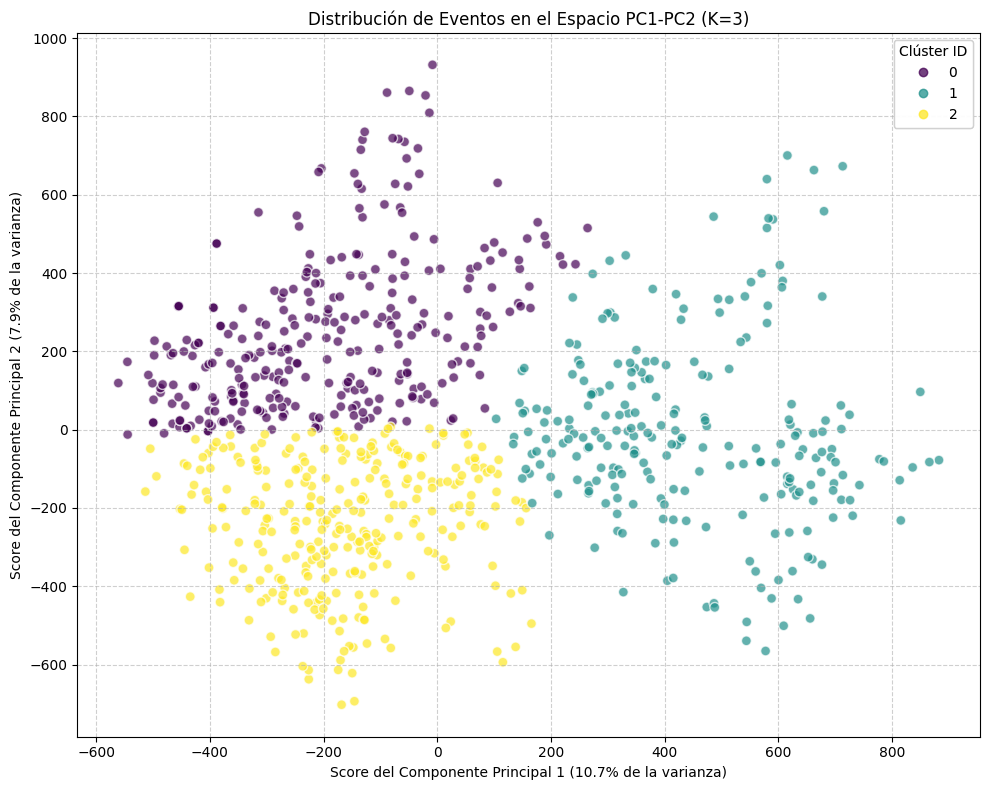

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

N_PCS_PLOT = 2 
k_clusters = 3
output_dir = 'pca_output' 

# Prepare data (scores for PC1 and PC2)
X_pcs_2d = scores[:, :N_PCS_PLOT] 
# labels = labels (Ya definido)

# Plotting 
plt.figure(figsize=(10, 8))

# Scatter plot: PC1 vs PC2, coloreado por cluster label
# Se usa 'c=labels' para diferenciar los 3 grupos.
scatter = plt.scatter(
    X_pcs_2d[:, 0], 
    X_pcs_2d[:, 1], 
    c=labels, 
    cmap='viridis', # Colores claros para los 3 clusters
    s=50,
    alpha=0.7,
    edgecolors='w' 
)

plt.xlabel(f'Score del Componente Principal 1 (10.7% de la varianza)')
plt.ylabel(f'Score del Componente Principal 2 (7.9% de la varianza)')
plt.title(f'Distribución de Eventos en el Espacio PC1-PC2 (K={k_clusters})')
plt.grid(True, linestyle='--', alpha=0.6)

# Leyenda
legend1 = plt.legend(*scatter.legend_elements(), 
                     title="Clúster ID", loc="upper right")
plt.gca().add_artist(legend1)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pc_scores_plot_colored.png"))
#plt.close()
plt.show()


K=3

PARA UNA SOLA FECHA

<xarray.Dataset> Size: 16MB
Dimensions:         (valid_time: 12, pressure_level: 1, latitude: 281,
                     longitude: 241)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 96B 2022-03-12 ... 2022-03-14...
  * pressure_level  (pressure_level) float64 8B 500.0
  * latitude        (latitude) float64 2kB 10.0 9.75 9.5 ... -59.5 -59.75 -60.0
  * longitude       (longitude) float64 2kB -90.0 -89.75 -89.5 ... -30.25 -30.0
    number          int64 8B ...
    expver          (valid_time) <U4 192B ...
Data variables:
    t               (valid_time, pressure_level, latitude, longitude) float32 3MB ...
    z               (valid_time, pressure_level, latitude, longitude) float32 3MB ...
    u               (valid_time, pressure_level, latitude, longitude) float32 3MB ...
    v               (valid_time, pressure_level, latitude, longitude) float32 3MB ...
    r               (valid_time, pressure_level, latitude, longitude) float32 3MB ...
Attributes:
    GRIB_centre:   

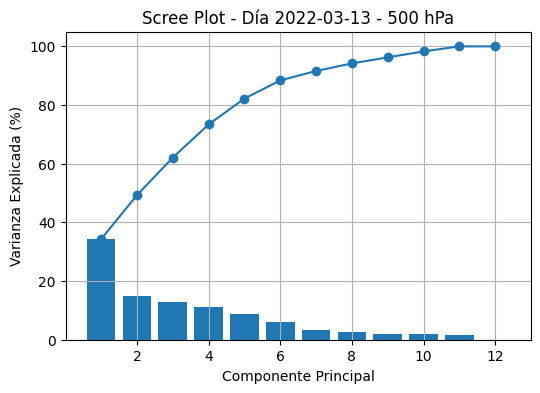

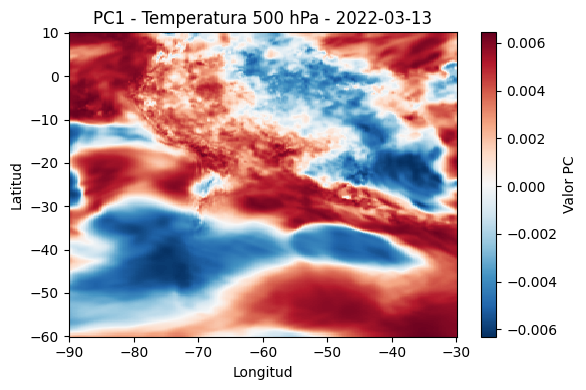

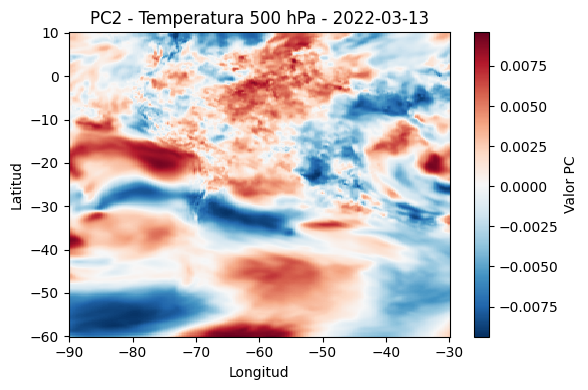

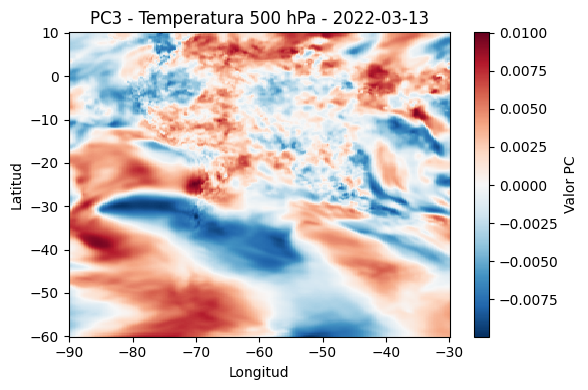

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

file = r"C:\Users\BERTHA\TP_2\final\ERA5_500hPa\ERA5_500hPa_2022\ERA5_500hPa_2022-03-13.nc"

ds = xr.open_dataset(file)

# Las coordenadas (para graficar)
lat = ds['latitude'].values
lon = ds['longitude'].values

t = ds['t']         # temperatura en K
print("Dimensiones:", t.dims)  

t2 = t.squeeze()    # (time, lat, lon)

ntime, nlat, nlon = t2.shape
print(ntime, nlat, nlon)

# reshape -> (tiempo, pixeles)
X = t2.values.reshape(ntime, nlat*nlon)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

pca = PCA()
PCs = pca.fit_transform(X_std)

expl = pca.explained_variance_ratio_
cumvar = np.cumsum(expl)

# Scree plot

plt.figure(figsize=(6,4))
plt.bar(np.arange(1, len(expl)+1), expl*100)
plt.plot(np.arange(1, len(expl)+1), cumvar*100, marker='o')
plt.xlabel("Componente Principal")
plt.ylabel("Varianza Explicada (%)")
plt.title("Scree Plot - Día 2022-03-13 - 500 hPa")
plt.grid(True)
plt.show()

components = pca.components_    

def pc_to_field(pc_vec):
    """Convierte un vector PCA a campo lat×lon"""
    return pc_vec.reshape(nlat, nlon)

PC1 = pc_to_field(components[0])
PC2 = pc_to_field(components[1])
PC3 = pc_to_field(components[2])


def plot_pc(field, title):
    plt.figure(figsize=(6,4))
    plt.pcolormesh(lon, lat, field, cmap="RdBu_r")
    plt.colorbar(label='Valor PC')
    plt.title(title)
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.tight_layout()
    plt.show()

plot_pc(PC1, "PC1 - Temperatura 500 hPa - 2022-03-13")
plot_pc(PC2, "PC2 - Temperatura 500 hPa - 2022-03-13")
plot_pc(PC3, "PC3 - Temperatura 500 hPa - 2022-03-13")


El tercer componente principal (PC3) muestra un patrón dominado por un dipolo latitudinal, con cargas positivas sobre la Amazonía y norte de Sudamérica, y cargas negativas en el dominio extratropical al sur de 30°S. Esto sugiere que el PC3 representa la interacción entre el calentamiento tropical y la dinámica baroclínica en el Pacífico Sur, posiblemente asociada a una onda de Rossby o una vaguada extratropical. El patrón es espacialmente coherente y físicamente consistente, indicando que el PCA capturó una estructura atmosférica real.

El número óptimo de PCs según el método del codo es: 3


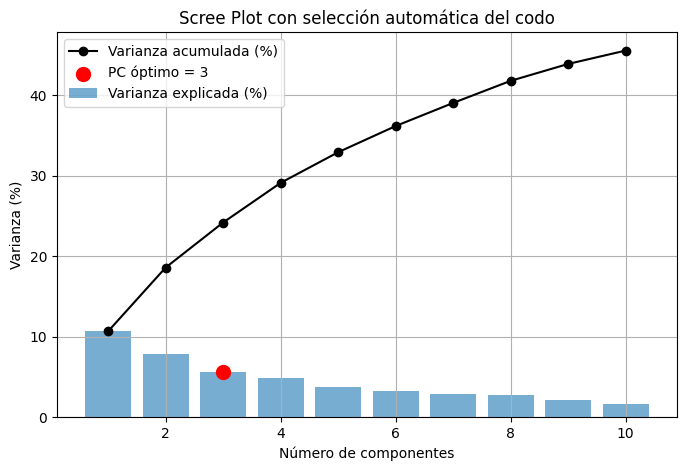

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

var_exp = ipca.explained_variance_ratio_

# Puntos de la curva
x = np.arange(1, len(var_exp) + 1)

x1, y1 = x[0], var_exp[0]
x2, y2 = x[-1], var_exp[-1]

# Calcular distancia de cada punto a esa línea
dist = np.abs((y2 - y1)*x - (x2 - x1)*var_exp + x2*y1 - y2*x1) / np.sqrt((y2 - y1)**2 + (x2 - x1)**2)

# Índice del máximo (PC del codo)
pc_optimo = dist.argmax() + 1

print(f"El número óptimo de PCs según el método del codo es: {pc_optimo}")

# Graficar el scree plot con el punto elegido
plt.figure(figsize=(8,5))
plt.bar(x, var_exp * 100, alpha=0.6, label="Varianza explicada (%)")
plt.plot(x, np.cumsum(var_exp) * 100, marker='o', color='black', label="Varianza acumulada (%)")
plt.scatter(pc_optimo, var_exp[pc_optimo-1] * 100, color='red', s=100, label=f"PC óptimo = {pc_optimo}")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza (%)")
plt.title("Scree Plot con selección automática del codo")
plt.grid(True)
plt.legend()
plt.show()


In [55]:
print("Varianza explicada acumulada:")
for i, v in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {v*100:.2f}%")


Varianza explicada acumulada:
PC1: 34.29%
PC2: 15.00%
PC3: 12.80%
PC4: 11.31%
PC5: 8.82%
PC6: 6.18%
PC7: 3.23%
PC8: 2.56%
PC9: 2.07%
PC10: 2.02%
PC11: 1.71%
PC12: 0.00%


In [56]:
def plot_pc(field, title, lat, lon):
    plt.figure(figsize=(6,4))
    plt.pcolormesh(lon, lat, field, cmap="RdBu_r", shading="auto")
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.tight_layout()
    plt.show()


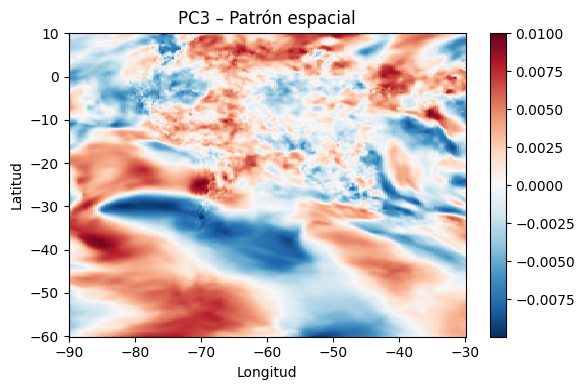

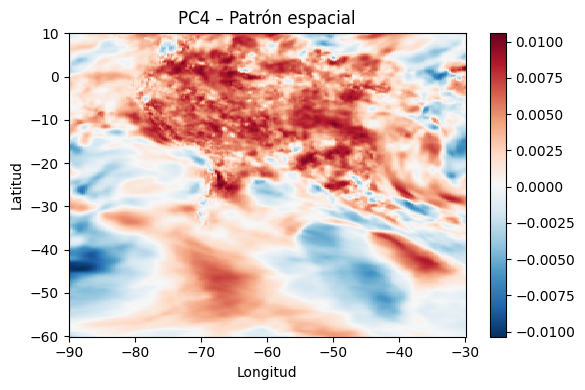

In [57]:
# PC3 → componente número 2 (índice 2)
pc3_map = pca.components_[2].reshape(nlat, nlon)

# PC4 → componente número 3 (índice 3)
pc4_map = pca.components_[3].reshape(nlat, nlon)

plot_pc(pc3_map, "PC3 – Patrón espacial", lat, lon)
plot_pc(pc4_map, "PC4 – Patrón espacial", lat, lon)


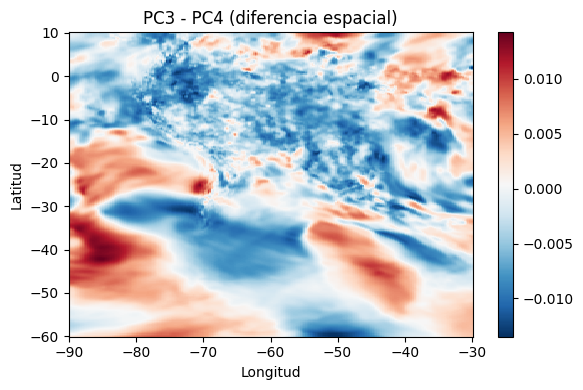

In [58]:
diff = pc3_map - pc4_map
plot_pc(diff, "PC3 - PC4 (diferencia espacial)", lat, lon)


In [59]:
from scipy.stats import pearsonr

corr, _ = pearsonr(pc3_map.flatten(), pc4_map.flatten())
print("Correlación espacial PC3–PC4:", corr)


Correlación espacial PC3–PC4: -0.045836244


Aunque el PC3 explica ligeramente más varianza, el PC4 presenta un patrón espacial de escala sinóptica clara, en este caso PC4 demuestra que es una variable diferente 

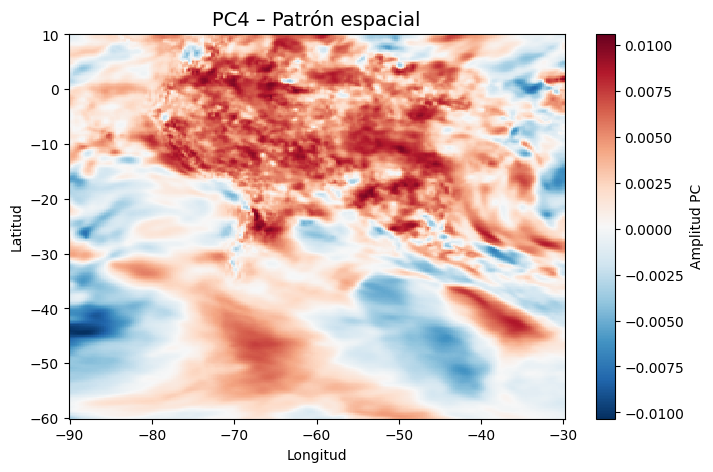

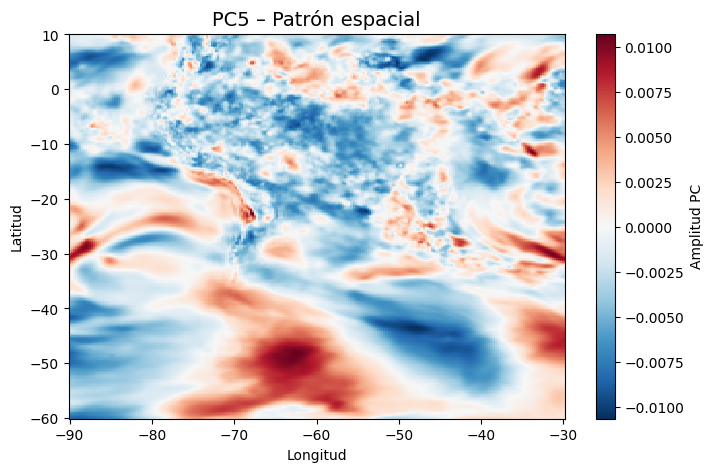

Correlación espacial PC4 – PC5: 0.14588817355711128


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pc_map(component_map, title, lat, lon):
    plt.figure(figsize=(8,5))
    plt.pcolormesh(lon, lat, component_map, shading='auto', cmap='RdBu_r')
    plt.title(title, fontsize=14)
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.colorbar(label="Amplitud PC")
    plt.show()

##(recordar que PC1 es índice 0)
pc4_map = pca.components_[3].reshape(nlat, nlon)

pc5_map = pca.components_[4].reshape(nlat, nlon)

plot_pc_map(pc4_map, "PC4 – Patrón espacial", lat, lon)
plot_pc_map(pc5_map, "PC5 – Patrón espacial", lat, lon)

corr = np.corrcoef(pc4_map.flatten(), pc5_map.flatten())[0,1]
print("Correlación espacial PC4 – PC5:", corr)


Para un análisis sinóptico real, PCA y K-means deben aplicarse usando todas las fechas disponibles, en este caso notamos que usar PC5 es innecesario, debido a la baja correlacion con PC4